# <center> **PROJECT-Агентство недвижимости**

### <center> **ПОСТАНОВКА ЗАДАЧИ:**

**Бизнес-задача:** разработать сервис для предсказания стоимости домов на основе истории предложений.


### <center> **ОСНОВНЫЕ ЦЕЛИ:**

* Сформировать набор данных на основе предоставленных источников информации;

* Спроектировать новые признаки с помощью *Feature Engineering* и выявить наиболее значимые при построении модели;

* Исследовать предоставленные данные и выявить закономерности;

* Построить несколько моделей и выбрать из них ту, которая показывает наилучший результат по заданной метрике;

* Спроектировать процесс предсказания стоимости домов для новых данных.


### <center> **ОРГАНИЗАЦИОННАЯ ИНФОРМАЦИЯ:**

Проект будет состоять из восьми частей:

`1.` **Базовый анализ и знакомство с данными**;

`2.` **Предобработка и очистка данных**;

`3.` **Разведывательный анализ данных (EDA)**;

`4.` **Подбор и преобразование признаков**;

`5.` **Machine Learning: AutoML**;

`6.` **Machine Learning: Linear Regression and Decision Trees**;

`7.` **Machine Learning: Ensemble Methods and Building a Forecast**;

`8.` **Improving prediction with the XGBoost model**.

## <center> **`1.` Базовый анализ и знакомство с данными**

**Импортируем необходимые библиотеки:**

In [1]:
# Для работы с данными
import pandas as pd
import numpy as np
import category_encoders as ce

# Для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Для сериализации и десериализации
import pickle

# Для регулярных выражений
import re

# Для создания и обучения модели
from scipy import stats
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree
from sklearn import metrics
import xgboost as xgb
import torch

# LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task          

**Прочитаем данные:**

In [2]:
# Загружаем DataFrame
REA_data = pd.read_csv('Прочие файлы/data.csv')

# Создаём копию
REA_df = REA_data.copy()

In [ ]:
# Выведем размерность данных
print(f'Размерность данных: {REA_df.shape}')

# Выведем первые пять строк
REA_df.head()

### <center> **Иформация о датасете**

* `status` - статус продажи;

* `private pool` и `PrivatePool` - наличие частного бассейна;

* `propertyType` - тип недвижимости, поместья, свойства;

* `street` - адрес дома;

* `baths` - количество ванных комнат;

* `homeFacts` - сведения о строении дома, содержит несколько отдельных данных, имеющих влияние на оценку недвижимости, дома, квартиры;

* `fireplace` - сведения о наличии камина (ов) в доме;

* `city` - город;

* `schools` - сведения о школах в районе;

* `sqft` - площадь дома в футах;

* `zipcode` - почтовый индекс;

* `beds` - количество спален в доме;

* `state` - государство/штаты;

* `stories` - этажность недвижимости;

* `mls-id` и `MlsId` - идентификатор *MLS* (*Multiple Listing Service* - Служба множественного листинга);

* `target` - целевой признак, который необходимо спрогнозировать - цена недвижимости;


Посмотрим на типизацию признаков:

In [3]:
REA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

## <center> **`2.` Предобработка и очистка данных**

#### $2.1$

#### В данных присутствуют числовые признаки типа *object*. Обработаем их и преобразуем в числовые типы данных.

##### **1.** Обрабатываем признак `zipcode`:

In [3]:
# Создаём функцию для удаления лишних символов
def delete_symbols_from_zipcode(string):
    string = str(string)
    
    if string[0].isdigit():
        if len(string) > 5:
            return string[:5]
        else:
            return string
    else:
        return np.nan
    


# Применяем полученную функцию к признаку 'zipcode'
REA_df['zipcode'] = REA_df['zipcode'].apply(delete_symbols_from_zipcode)

# Удаляем пропуски 
REA_df = REA_df.dropna(subset = ['zipcode'])

# Преобразовываем из типа 'object' в 'int'
REA_df['zipcode'] = REA_df['zipcode'].astype(int)

##### **2.** Обрабатываем признак `sqft`:

In [4]:
# Создаём функцию для извлечения чисел из строк 'Total interior livable area:'
def get_number_from_long_strings(string):
    
    if string != np.nan:
        string = str(string)
        if string[0] == 'T':
            return string[29:]
        else:
            return string
    else:
        return np.nan



# Создаём функцию для извлечения чисел из строк
def get_number(string):
    string_split = string.split()
    
    if len(string_split) > 1:
        string = string_split[0]
        
    if string == '--':
        string = 'nan'
    
    return string.replace(',', '')



# Создаём функцию для преобразования признака 'sqft' к типу float
def changing_from_object_to_int(string):
    
    if string != 'nan' and string != '610-840':
        string = float(string)
    else:
        string = np.nan
        
    return string



# Применяем полученные функции к признаку 'sqft'    
REA_df['sqft'] = REA_df['sqft'].apply(get_number_from_long_strings)
REA_df['sqft'] = REA_df['sqft'].apply(get_number)
REA_df['sqft'] = REA_df['sqft'].apply(changing_from_object_to_int)

##### **3.** Обрабатываем признак `target`:

In [5]:
# Создадим функцию для удаления знака лишних символов из всех строк
def get_numbers(string):
    string = str(string)
    list_symbols = [',', '+', '$', '/mo']
    
    for symbol in string:
        if symbol in list_symbols:
            string = string.replace(symbol, '')
            
    return string



# Создаём функцию для преобразования признака 'target' к типу float
# а так же удаления лишних значений
def changing_from_object_to_int(string):
    
    if string != 'nan' and string[-3:] != '/mo':
        string = float(string)
    else:
        string = np.nan
        
    return string



# Применяем плученные функции к признаку 'target'
REA_df['target'] = REA_df['target'].apply(get_numbers)
REA_df['target'] = REA_df['target'].apply(changing_from_object_to_int)

##### **4.** Обрабатываем признак `homeFacts`:

In [6]:
# Создаём функцию для выделения меры акра
def get_lotsize_measure(home_facts_str):
    if re.search(r"acre['s]*", home_facts_str):
        return 'acre'
    
    return None



# Создаём функцию для удаления лишних символов и строк из признака 'homeFacts'
def process_home_facts(home_facts):
    
    # Приводим строки к нижнему регистру
    home_facts = home_facts.lower()
    
    # Удаляем запятые между цифрами
    home_facts = re.sub(r'(\d), (\d)', r'\1\2', home_facts)
    
    # Удаляем символ '$'
    home_facts = home_facts.replace('$', '')
    
    # Удаляем строки ' sqft', ' sq. ft.' и ' acres'
    home_facts = home_facts.replace(' sqft', '')
    home_facts = home_facts.replace('/sqft', '')
    home_facts = home_facts.replace(' sq. ft.', '')
    
    # Удаляем строки ' lot', ' acre' и 'contact manager'
    home_facts = home_facts.replace(' lot', '')
    home_facts = home_facts.replace(' acres', '')
    home_facts = home_facts.replace(' acre', '')
    home_facts = home_facts.replace('contact manager', '')
    
    # Удаляем строки ' /', '—', '-' и 'no info'
    home_facts = home_facts.replace('—', '')
    home_facts = home_facts.replace('-', '')
    home_facts = home_facts.replace(' /', '')
    home_facts = home_facts.replace('no info', '')
    
    # Вернём полученную строку
    return home_facts



# Создаём новый признак, обозначающий земельную меру акр
REA_df['lotsize_measure'] = REA_df['homeFacts'].apply(get_lotsize_measure)

# Приведём значения признака 'homeFacts' к нижнему регистру
REA_df['homeFacts'] = REA_df['homeFacts'].apply(lambda x: str(x).lower())


# Переберём каждую строку признака 'homeFacts',
# и применим функцию process_home_facts()
for i, row in REA_df.iterrows():
    home_facts = row['homeFacts']
    home_facts = process_home_facts(home_facts)
    REA_df.at[i, 'homeFacts'] = home_facts
    
# Создаём шаблон регулярного выражения соответствующего паре ключ-значение в строке
reg_pattern = r"{'factvalue': '(.*?)', 'factlabel': '(.*?)'}"

Из признака `homeFacts` создадим следующие признаки:

- `year built` - год постройки;
- `remodeled year` - год реконструкции;
- `heating` - отопление;
- `cooling` - кондиционирование;
- `parking` - парковочные места;
- `lotsize` - площадь объекта;
- `price` - цена.

In [7]:
# Переберём каждую строку признака 'homeFacts', выделяя из него необходимые значения,
# и создавая из этих значений новые признаки
for i, row in REA_df.iterrows():
    home_facts_str = row['homeFacts']
    
    # Вычислим все пары ключ-значение в строке
    matches = re.finditer(reg_pattern, home_facts_str)
    home_facts = {}
    
    for match in matches:
        factvalue = match.group(1)
        factlabel = match.group(2)
        home_facts[factlabel] = factvalue
    
        
    # Обновим строку, используя извлеченные пары ключ-значение, преобразуя их в соответствующий тип данных.
    # 'year_built' и 'remodeledyear' - int
    year_built = home_facts.get('year built', None)
    if year_built is None or year_built == 'no data' or year_built == '':
        REA_df.at[i, 'year built'] = None
    else:
        REA_df.at[i, 'year built'] = int(year_built)
        
    remodeled_year = home_facts.get('remodeled year', None)
    if remodeled_year is None or remodeled_year == 'no data' or remodeled_year == '':
        REA_df.at[i, 'remodeled year'] = None
    else:
        REA_df.at[i, 'remodeled year'] = int(remodeled_year)
     
     
    # 'heating', 'cooling', 'parking' - str
    REA_df.at[i, 'heating'] = home_facts.get('heating', None)
    REA_df.at[i, 'cooling'] = home_facts.get('cooling', None)
    REA_df.at[i, 'parking'] = home_facts.get('parking', None)
    
    
    # 'lotsize', ' price' - float
    lot_size = home_facts.get('lotsize', None)
    if lot_size is None or lot_size == 'no data' or lot_size == '':
        REA_df.at[i, 'lotsize'] = None
    else:
        REA_df.at[i, 'lotsize'] = lot_size
        
    price_sqft = home_facts.get('price', None)
    if price_sqft is None or price_sqft == 'no data' or price_sqft == '':
        REA_df.at[i, 'price'] = None
    else:
        REA_df.at[i, 'price'] = price_sqft

##### **5.** Обрабатываем признак `year built`:

In [8]:
# Удалим строки с пропущенными значениями в признаке 'year built'
REA_df = REA_df.dropna(subset = ['year built'])

# Приведём признак 'year built' к типу int
REA_df['year built'] = REA_df['year built'].astype(int)

Проведём небольшое исследование признака:

In [9]:
# Выведем минимальное значение 
print('Минимальное значение признака: {}'.format(REA_df['year built'].min()))

# Выведем максимальное значение
print('Максимальное значение признака: {}'.format(REA_df['year built'].max()))

Минимальное значение признака: -2147483648
Максимальное значение признака: 2025


В данных присутствуют отрицательные значения, а также ещё не наступившие годы потройки. Выведем информацию о количестве таких значений:

In [10]:
# Возьмём данные до 1800 и после 2022 года
periods = REA_df[(REA_df['year built'] < 1800) | (REA_df['year built'] > 2022)]
print('Количество записей за периоды до 1800 и после 2022 года: {}'.format(periods.shape[0]))

Количество записей за периоды до 1800 и после 2022 года: 31


Так как количество полученных записей пренебрежимо мало, удалим их:

In [11]:
REA_df = REA_df.drop(periods.index, axis = 0)

# Выведем результирующее число записей
print('Результирующее число записей: {}'.format(REA_df.shape[0]))

Результирующее число записей: 313557


##### **6.** Обрабатываем признак `schools`:

In [12]:
# Приведём значения признака 'schools' к типу str
REA_df['schools'] = REA_df['schools'].astype(str)



# Выделим значения рейтингов школ в отдельный признак, а также удалим ненужные символы
REA_df['schools_rating'] = REA_df['schools'].apply(lambda x: re.sub(r'data.*', '', x))
REA_df['schools_rating'] = REA_df['schools_rating'].apply(lambda x: re.sub(r'/10', '', x))
REA_df['schools_rating'] = REA_df['schools_rating'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))
REA_df['schools_rating'] = REA_df['schools_rating'].apply(lambda x: x.replace('rating', ''))
REA_df['schools_rating'] = REA_df['schools_rating'].apply(lambda x: x[:-2])
REA_df['schools_rating'] = REA_df['schools_rating'].apply(lambda x: x[1:])



# Создадим новый столбец под названием 'school_count', который будет подсчитано количество школ
REA_df['school_count'] = REA_df['schools_rating'].apply(lambda x: (len(x.split(','))) if x != '' else 0)
REA_df['school_count'] = REA_df['school_count'].astype('int')



# Удалим все буквы
REA_df['schools_rating'] = REA_df['schools_rating'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))
# Удалим запятые перед цифрами
REA_df['schools_rating'] = REA_df['schools_rating'].apply(lambda x: re.sub(r'\s+,', '', x))
# Удалим запятые на конце
REA_df['schools_rating'] = REA_df['schools_rating'].apply(lambda x: x[:-1])



# Создадим новый признак 'schools_rating_list'
REA_df['schools_rating_list'] = REA_df['schools_rating'].apply(lambda x: [int(i) for i in re.findall(r'\d+', x)])



# Создадим новый признак 'schools_rating_ave'
REA_df['schools_rating_average'] = REA_df['schools_rating_list'].apply(lambda x: round(sum(x) / len(x), 2) if len(x) > 0 else 0)



# 0 в 'schools_rating_ave' представляет собой отсутствующие значения.
# Однако это можно интерпретировать как действительно плохие школы.
# Заменим 0 на среднее значение.
REA_df['schools_rating_average'] = REA_df['schools_rating_average'].apply(np.round, decimals = 2)

# Подсчитаем средние значения признака 'schools_rating_average'
average_values = REA_df['schools_rating_average'].mean()

# Заменим нулевые значения на средние
REA_df['schools_rating_average'] = REA_df['schools_rating_average'].apply(lambda x: average_values if x < 1 else x)



# Создадим функцию для выделения информации о расстоянии
def extract_text(text):
    
    # Используем шаблон регулярного выражения, чтобы извлечь текст между 'Distance' и 'Grades'
    reg_pattern = r"Distance': \['(.+?)'\], 'Grades'"
    match = re.search(reg_pattern, text)
    
    if match:
        return match.group(1) # возвращаем найденную строку
    else:
        return None           # возвращаем None в случае, если искомая строка не найдена
    
    
    
# Создаём признак расстояния до школы, а также переведём его в тип str
REA_df['schools_distance'] = REA_df['schools'].apply(extract_text)
REA_df['schools_distance'] = REA_df['schools_distance'].astype(str)

# Удаляем символ ' mi', а также другие ненужные символы
REA_df['schools_distance'] = REA_df['schools_distance'].apply(lambda x: re.sub(r'\smi', '', x))
REA_df['schools_distance'] = REA_df['schools_distance'].str.replace(r'[^\d., \s]', '', regex=True)

# Заменим пустые строки на списки вещественных чисел
REA_df['schools_distance'] = REA_df['schools_distance'].apply(lambda x: [float(num) for num in x.split(',')] if x else [])

# Создаём признак среднего расстояния
REA_df['schools_distance_average'] = REA_df['schools_distance'].apply(lambda x: round(sum(x)/len(x), 2) if x else 0)

##### **7.** Обрабатываем признак `state`:

Для удобства заменим сокращённые названия штатов на полные:

In [13]:
# Создадим функцию для замены сокращённых названий штатов на полные
def get_state(arg):
    
    # Создадим словарь, в котором ключами будут сокращённые названия штатов,
    # а значения - полные названия
    state_dict = {
        'FL': 'Florida',
        'TX': 'Texas',
        'CA': 'California',
        'NY': 'New York City',
        'NC': 'North Carolina',
        'TN': 'Tennessee',
        'WA': 'Washington',
        'OH': 'Ohio',
        'IL': 'Illinois',
        'NV': 'Nevada',
        'CO': 'Colorado',
        'GA': 'Georgia',
        'PA': 'Pennsylvania',
        'MI': 'Michigan',
        'DC': 'Washington, D.C.',
        'IN': 'Indiana',
        'AZ': 'Arizona',
        'OR': 'Oregon',
        'MA': 'Massachusetts',
        'UT': 'Utah',
        'MD': 'Maryland',
        'MO': 'Missouri',
        'VA': 'Virginia',
        'VT': 'Vermont',
        'WI': 'Wisconsin',
        'NJ': 'New Jersey',
        'IA': 'Iowa',
        'ME': 'Maine',
        'KY': 'Kentucky',
        'OK': 'Oklahoma',
        'MS': 'Mississippi',
        'SC': 'South Carolina',
        'MT': 'Montana',
        'DE': 'Delaware',
        'Fl': 'Florida'
    }
    
    # Производим замену сокращённого названия на полное
    if arg in state_dict.keys():
        return state_dict[arg]



# Применяем полученную функцию к признаку 'state'        
REA_df['state'] = REA_df['state'].apply(get_state)

##### **8.** Обрабатываем признак `street`:

In [14]:
# Заменим строки, указывающих на неизвестность адреса, одной строкой 'Undisclosed Address'
REA_df['street'] = REA_df['street'].apply(lambda x: 'Undisclosed Address' if x == 'Address Not Disclosed' or x == '(undisclosed Address)' else x)

##### **9.** Обрабатываем признак `propertyType`:

In [15]:
# Удалим строки с пропущенными значениями в признаке 'propertyType'
REA_df = REA_df.dropna(subset = ['propertyType'])

# Приведём признак 'propertyType' к типу str
REA_df['propertyType'] = REA_df['propertyType'].astype(str)

Многие уникальные названия помещений можно сгруппировать и отнести к общим типам помещений. 

Произведём такую группировку, при этом сократим количество уникальных значений:

In [16]:
# Создаем списки с уникальными значениями
single_list = ['single-family', 'Single-Wide', 'Single']
multi_list = ['Multi', 'Multi-Family', 'Multiple', 'Multiplex', 'Multi-Level,', 'Multi-Level']
condo_list = ['Condo', 'Condo/Townhome/Row', 'Condo/Townhome,', 'Condo/Townhome', 'Condominium', 'Condo/Unit', 'Condo/Unit,']
detached_list = ['Detached,', 'Detached']
townhouse_list = ['townhouse', 'Townhouse', 'Townhouse,', 'Townhouse-Interior', 'Townhouse-End']
mobile_list = ['Mobile', 'mobile/manufactured']



# Напишем функцию с помощью которой похожие уникальные значения объединим одним названием
def get_type(string):
    
    # Преобразовываем строку в список
    split_string = string.split()
    
    # Выделяем тип помещения
    for area_type in split_string:
        if area_type in single_list:
            return 'Single area',
        elif area_type in multi_list:
            return 'Multiple area',
        elif area_type in condo_list:
            return 'Condominiums',
        elif area_type in detached_list:
            return 'Detached area',
        elif area_type in townhouse_list:
            return 'Townhouse',
        elif area_type in mobile_list:
            return 'Mobile area'
        else:
            return 'Other area'
        
        
        
# Применяем полученную функцию к признаку 'propertyType'
REA_df['propertyType'] = REA_df['propertyType'].apply(get_type)

# Создаём список со значениями типа tuple
values_with_symbols = [('Single area',), ('Condominiums',), ('Townhouse',), ('Multiple area',), ('Detached area',)]

# Приводим значения типа tuple к типу str
REA_df['propertyType'] = REA_df['propertyType'].apply(lambda x: ''.join(x) if x in values_with_symbols else x)

#### $2.2$

#### Проверим данные на наличие пропусков:

Суммарное количество пропусков в данных: 1783794 

Информация по количествам пропусков: 

status                       35338
private pool                292090
propertyType                    92
street                           1
baths                        53189
homeFacts                        0
fireplace                   197011
city                             9
schools                          0
sqft                          6147
zipcode                          0
beds                         38589
state                            0
stories                      90055
mls-id                      271699
PrivatePool                 259307
MlsId                        54074
target                        2470
lotsize_measure             243825
year built                       0
remodeled year              157645
heating                          0
cooling                          0
parking                        330
lotsize                      61753
price                        20170


<AxesSubplot:>

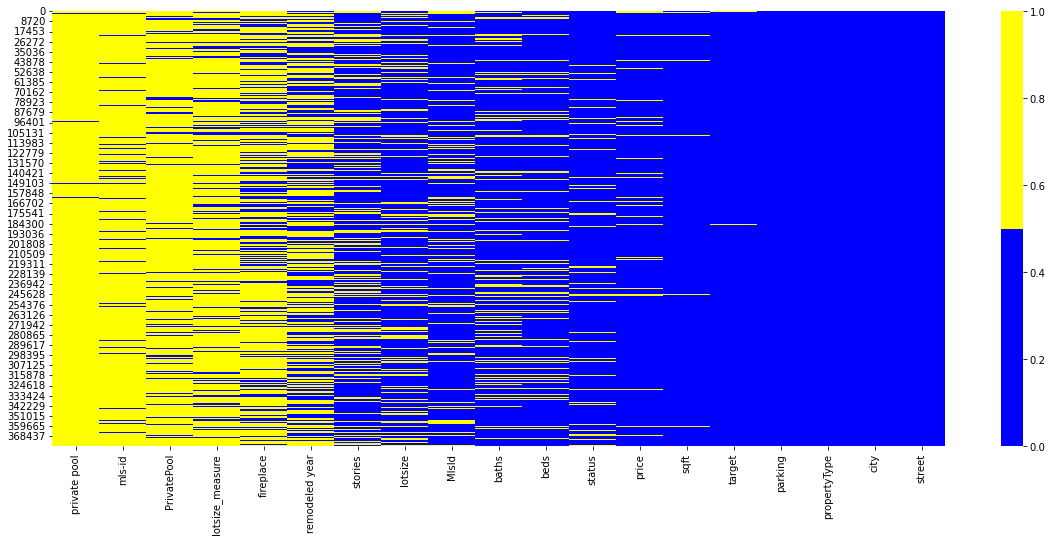

In [17]:
# Выводим суммарное количество пропусков
print('Суммарное количество пропусков в данных: {} \n'.format(REA_df.isnull().sum().sum()))

# Выводим признаки с сумрным количеством пропусков
print('Информация по количествам пропусков: \n\n{} \n'.format(REA_df.isnull().sum()))



# Построим тепловую карту пропусков
# Создаём функцию отображения пропущенных значений на тепловой карте
def missing_values_heatmap(data):
    
    # Рассчитываем количество пропусков
    cols_null_persent = data.isnull().mean() * 100
    cols_with_null = cols_null_persent[cols_null_persent > 0].sort_values(ascending = False)
    print(cols_with_null)
    
    # Задаём параметры графика
    colors = ['blue', 'yellow']
    fig = plt.figure(figsize = (20, 8))
    cols = cols_with_null.index
    
    # Строим тепловую карту
    ax = sns.heatmap(
        data = data[cols].isnull(),
        cmap = sns.color_palette(colors)
    )
    
    return ax


# Применяем полученную функцию к нашему датасету
missing_values_heatmap(REA_df)

Из расчёта количества пропусков видно, что признаки `private pool`, `mls-id`, `PrivatePool`, `fireplace`, `stories`, `baths`, `lotsize_measure`, `remodeled year`, `lotsize`, `price` и `beds` содержат от 20% пропусков, поэтому будет целесообразно их удалить;

Также удалим признаки `homeFacts`, `schools`, `schools_rating`, `schools_rating_list`, `schools_distance`, `MlsId`, `status`, `zipcode`, `street` и `price`, так как особой ценности они не представляют:

In [18]:
# Создаём список признаков для удаления
features_for_delete = [
    'status',
    'zipcode',
    'street',
    'private pool',
    'mls-id',
    'MlsId',
    'PrivatePool',
    'fireplace',
    'stories',
    'baths',
    'beds',
    'lotsize_measure',
    'remodeled year',
    'lotsize',
    'price',
    'homeFacts',
    'schools',
    'schools_rating',
    'schools_rating_list',
    'schools_distance'
]



# Производим удаление
for features in features_for_delete:
    REA_df = REA_df.drop(features, axis = 1)

Обработаем пропущенные значения:

In [19]:
# Создаём словарь имя столбца: число (признак) на который надо заменить пропуски
values = {
    'sqft': REA_df['sqft'].mean(),
    'target': REA_df['target'].median(),
    'city': REA_df['city'].mode()[0],
    'propertyType': REA_df['propertyType'].mode()[0],
    'heating': REA_df['heating'].mode()[0],
    'cooling': REA_df['cooling'].mode()[0],
    'parking': REA_df['parking'].mode()[0]
}

# Заполняем пропуски в соответствии с заявленным словарем
REA_df = REA_df.fillna(values)

# Удаляем пропуски в признаке 'state'
REA_df = REA_df.dropna(subset = ['state'])

# Выводим результирующую долю пропусков
REA_df.isnull().mean()

propertyType                0.0
city                        0.0
sqft                        0.0
state                       0.0
target                      0.0
year built                  0.0
heating                     0.0
cooling                     0.0
parking                     0.0
school_count                0.0
schools_rating_average      0.0
schools_distance_average    0.0
dtype: float64

#### $2.3$

#### Проверим наличие дубликатов:

In [20]:
# Создаём список признаков
dupl_columns = list(REA_df.columns)


# Создаём маску дубликатов с помощью метода duplicated() и произведём фильтрацию
mask = REA_df.duplicated(subset = dupl_columns)
REA_duplicates = REA_df[mask]
print(f'Число найденных дубликатов: {REA_duplicates.shape[0]}')

Число найденных дубликатов: 1811


Удалим найденные дубликаты:

In [21]:
REA_df = REA_df.drop_duplicates(subset = dupl_columns)
print(f'Результирующее число записей: {REA_df.shape[0]}')


# Вычеслим оставшееся количество дубликатов
mask = REA_df.duplicated(subset = dupl_columns)
REA_duplicates = REA_df[mask]
print(f'Количество дубликатов после обработки: {REA_duplicates.shape[0]}')

Результирующее число записей: 294435
Количество дубликатов после обработки: 0


#### $2.4$

#### При изучении признаков было выявлено, что в признаке `school_count` присутствуют нулевые значения.

**1.** Выведем количество нулевых площадей (`school_count`):

In [22]:
# Рассчитаем количество и процентное количество школ
school_count_zero = REA_df[REA_df.school_count == 0]
school_count_zero_percent = (school_count_zero.shape[0] / REA_df.school_count.shape[0]) * 100


# Выведем полученные значения
print('Количество отсутствующих школ: {}'.format(school_count_zero.shape[0]))
print(f'Процентное количество отсутствующих школ: {round(school_count_zero_percent, 2)}%')

Количество отсутствующих школ: 2310
Процентное количество отсутствующих школ: 0.78%


Количество нулевых значений в признаке меньше 1%, поэтому от них можно избавиться:

In [23]:
# Произведём удаление нулевых значений
REA_df = REA_df[REA_df['school_count'] != 0]

# Выведем количество записей
print(f'Количество записей таблицы: {REA_df.shape[0]}')

Количество записей таблицы: 292125


#### $2.5$

#### Проверим данные на наличие выбросов.

##### **1.** Разберём признак `sqft`:

Построим две гистограммы признака жилой площади (`sqft`): первая — в обычном масштабе, а вторая — в логарифмическом:

p = 0.00
Данные не распределены нормально (мы отклоняем H0)


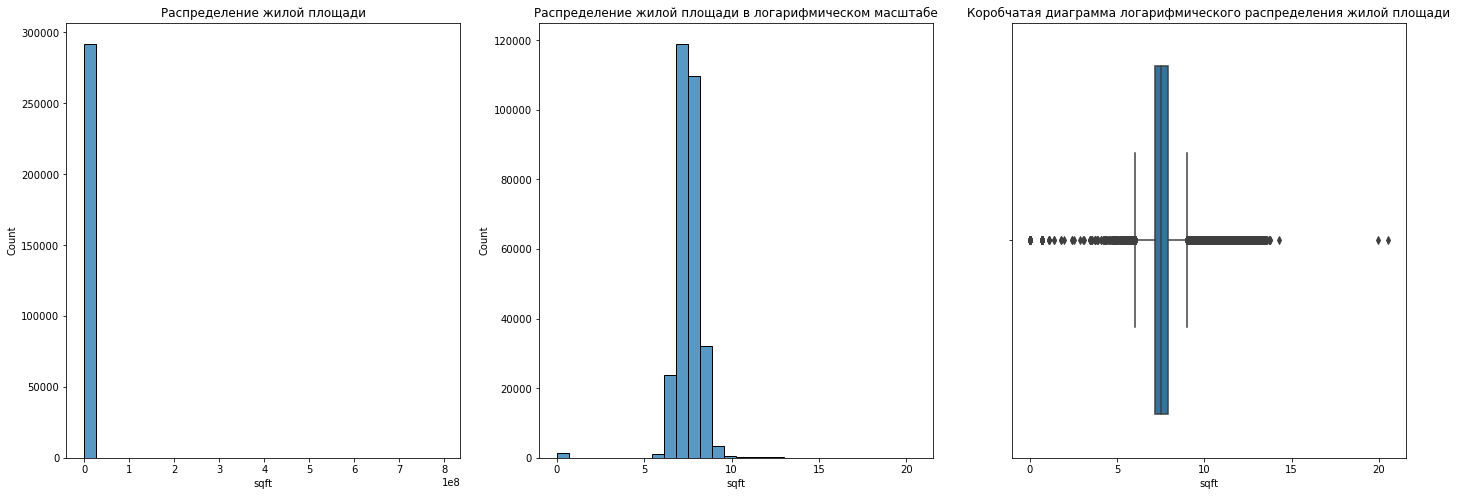

In [24]:
# Задаём параметры графиков
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 3,
    figsize = (24, 8)
)



# Гистограмма исходного признака 
histplot = sns.histplot(
    data = REA_df['sqft'],
    bins = 30,
    ax = axes[0]
)

# Название графика
histplot.set_title('Распределение жилой площади');



# Гистограмма в логарифмическом масштабе
sqft_log = np.log(REA_df['sqft'] + 1)
histplot = sns.histplot(
    data = sqft_log,
    bins = 30,
    ax = axes[1]
)

# Название графика
histplot.set_title('Распределение жилой площади в логарифмическом масштабе')



# Строим коробчатую диаграмму
boxplot = sns.boxplot(
    data = REA_df,
    x = sqft_log,
    ax = axes[2]
)

# Задаём название коробчатой диаграммы
boxplot.set_title('Коробчатая диаграмма логарифмического распределения жилой площади')



# Формируем нулевую и альтернативную гипотезы для тестирования данных на нормальность распределения
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отклоняем H0)'

# Задаём уровень значимости
alpha = 0.05

# Тест D'Agostino
_, p = stats.normaltest(sqft_log)
print('p = %.2f' % p)

# Интерпретация
if p > alpha/2:
    print(H0)
else:
    print(Ha)

Из первого графика нельзя сделать определённых выводов в отличие от второго. 

Взяв натуральный логарифм от левого распределения, мы получаем правое, которое напоминает слегка перекошенное нормальное. Справа от моды (самого высокого столбика) наблюдается чуть больше наблюдений, нежели справа.

Реализуем алгоритм метода *z*-отклонения. Описание алгоритма метода:

→ вычислить математическое ожидание *m* (среднее) и стандартное отклонение *o* признака *x*;

→ вычислить нижнюю и верхнюю границу интервала как:

**bound(lower) = m - 3o**
**bound(upper) = m + 3o**

→ найти наблюдения, которые выходят за пределы границ.

✍️ Напишем функцию **outliers_z_score()**, которая реализует этот алгоритм. 

На вход она принимает *DataFrame* и признак, по которому ищутся выбросы. В дополнение добавим в функцию возможность работы в логарифмическом масштабе: для этого введём аргумент *log_scale*. Если он равен *True*, то будем логарифмировать рассматриваемый признак, иначе — оставляем его в исходном виде. 

Затем применим эту функцию к таблице *REA_df* и признаку `sqft`, а также выведем размерности результатов.

Функция будет возвращать выбросы и очищенные от них данные:

In [25]:
# Находим выбросы с помощью метода z-отклонения и удалим их из данных
def outliers_z_score(data, feature, log_scale = False):
    
    if log_scale:
        x  = np.log(data[feature] + 1)
    else:
        x = data[feature]
        
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
    return outliers, cleaned



# Применим полученную функцию к датафрейму и к признаку 'sqft'
outliers, cleaned = outliers_z_score(REA_df, 'sqft', log_scale = True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')



# Выводим выбросы
print('\nПотенциальные выбросы: {}'.format(outliers['sqft'].unique()))

Число выбросов по методу z-отклонения: 2666
Результирующее число записей: 289459

Потенциальные выбросы: [0.00000000e+00 1.07250000e+05 1.09200000e+05 2.25667000e+05
 3.73772000e+05 7.18380000e+04 1.00000000e+00 1.42075000e+05
 1.14151000e+05 3.27670000e+04 2.06511000e+05 6.88680000e+04
 1.05996000e+05 1.40370000e+05 2.60961000e+05 3.32660000e+05
 6.59200000e+04 3.63000000e+05 1.57080000e+05 5.26000000e+04
 4.65000000e+04 3.38373000e+05 1.70080000e+05 2.60000000e+04
 3.24261000e+05 4.04890000e+05 8.00000000e+04 6.00000000e+00
 3.95850000e+05 1.99464000e+05 1.15914000e+05 9.46850000e+04
 2.76203000e+05 2.59860000e+04 1.08939000e+05 2.40000000e+04
 4.06920000e+04 1.42470000e+05 9.17450000e+04 1.00000000e+02
 9.11700000e+04 7.50100000e+04 8.02820000e+04 4.63500000e+05
 1.12500000e+05 1.19000000e+05 3.08000000e+04 3.22000000e+04
 5.08200000e+04 2.18364000e+05 4.59500000e+04 2.02841000e+05
 8.44450000e+04 1.51000000e+02 3.60000000e+04 1.18443000e+05
 3.99204000e+05 9.35640000e+04 1.90640000

Теперь отдельно построим гистограмму прологарифмированного распределения, а также отобразим на гистограмме вертикальные линии, соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала. Вертикальные линии можно построить с помощью метода *axvline()*. Для среднего линия будет обычной, а для границ интервала — пунктирной (параметр *ls ='--'*):

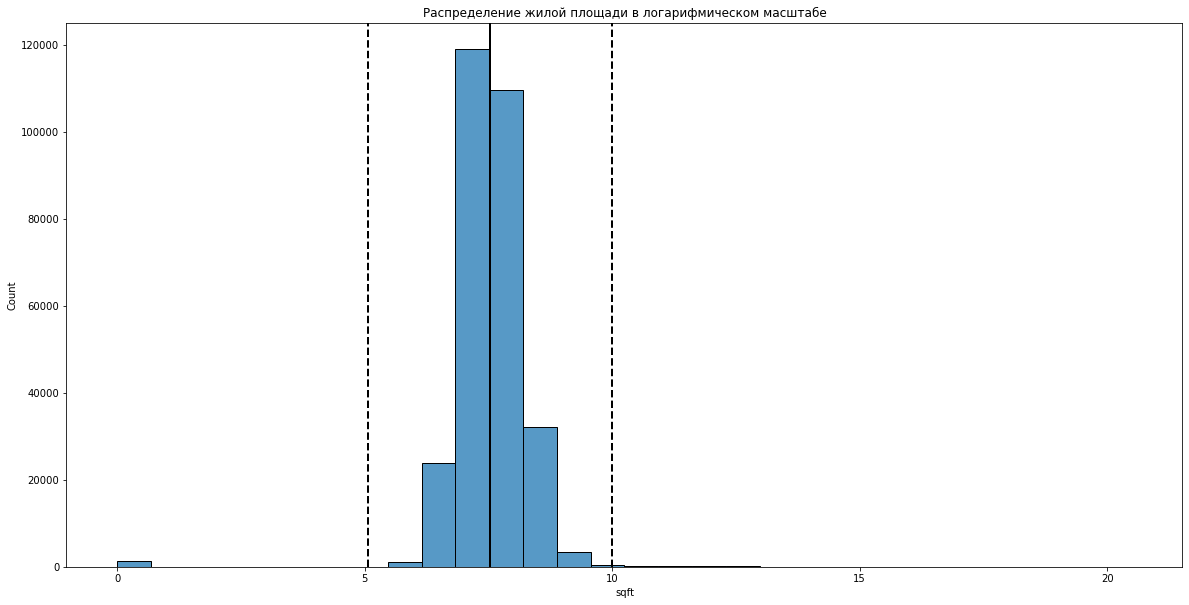

In [26]:
# Задаём параметры графиков
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (20, 10)
)



# Логарифмируем признак (прибавляем 1, т.к. логарифма от 0 не существует)
sqft_log = np.log(REA_df['sqft'] + 1)



# Строим гистограмму
histplot = sns.histplot(
    data = sqft_log,
    bins = 30,
    ax = ax
)

# Строим вертикальные линии
histplot.axvline(sqft_log.mean(), color = 'k', lw = 2)
histplot.axvline(sqft_log.mean() + 3 * sqft_log.std(), color='k', ls='--', lw=2)
histplot.axvline(sqft_log.mean() - 3 * sqft_log.std(), color='k', ls='--', lw=2)

# Название графика
histplot.set_title('Распределение жилой площади в логарифмическом масштабе');

Из данного интервала легко заметить, среднее значение (жирная вертикальная линия) находится правее моды, это свойство распределений с правосторонней асимметрией. Также видны наблюдения, которые мы не захватили своим интервалом, также одно из наблюдений попало под разделяющую линию. Попробуем немного (меньше чем на одну сигму) "сдвинуть" верхнюю границу вправо, чтобы захватить данное наблюдение.

In [27]:
def outliers_z_score(data, feature, log_scale = False, left = 3, right = 3.5):
    
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
        
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    data = data[(x > lower_bound) & (x < upper_bound)]
    
    return outliers, data



# Применим полученную функцию к датафрейму и к признаку 'sqft'
outliers, REA_df = outliers_z_score(REA_df, 'sqft', log_scale = True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {REA_df.shape[0]}')

Число выбросов по методу z-отклонения: 2503
Результирующее число записей: 289622


Повторно построим гистограмму прологарифмированного распределения:

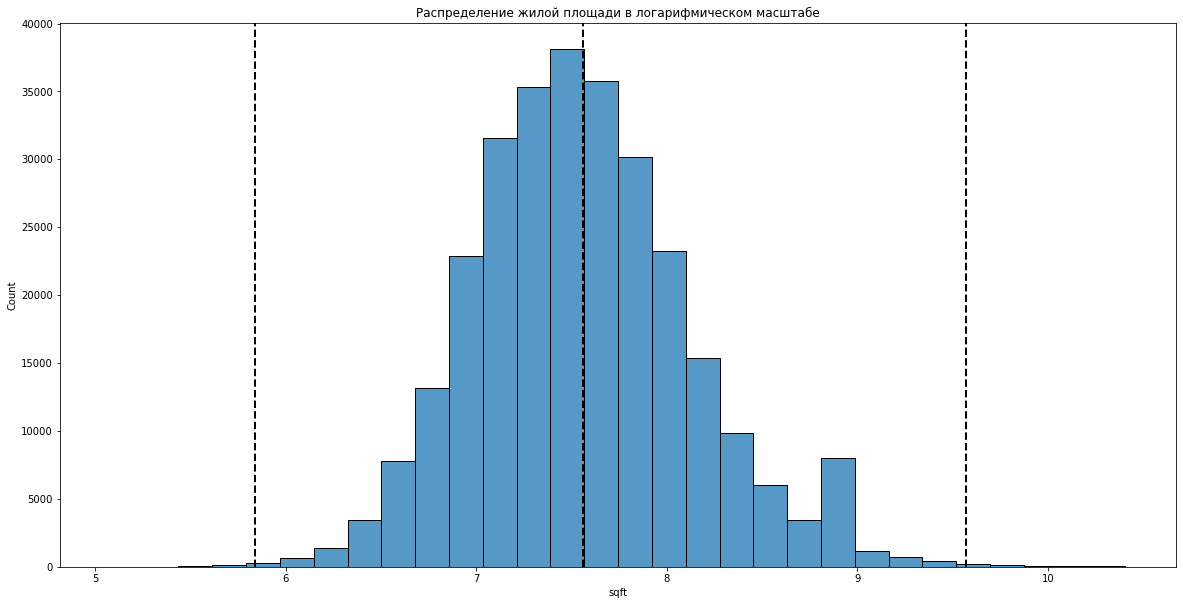

In [28]:
# Задаём параметры графика
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (20, 10)
)



# Логарифмируем признак 'sqft
sqft_log = np.log(REA_df['sqft'] + 1)



# Строим гистограмму
histplot = sns.histplot(
    data = sqft_log,
    bins = 30,
    ax = ax
)

# Строим вертикальные линии
histplot.axvline(sqft_log.mean(), color='k', ls='--', lw=2)
histplot.axvline(sqft_log.mean() + 3.5 * sqft_log.std(), color='k', ls='--', lw=2)
histplot.axvline(sqft_log.mean() - 3 * sqft_log.std(), color='k', ls='--', lw=2)

# Название графика
histplot.set_title('Распределение жилой площади в логарифмическом масштабе');

##### **2.** Разберём признак `target`.

Построим две гистограммы признака стоимости жилого помещения (`target`): первая — в обычном масштабе, а вторая — в логарифмическом:

p = 0.00
Данные не распределены нормально (мы отклоняем H0)


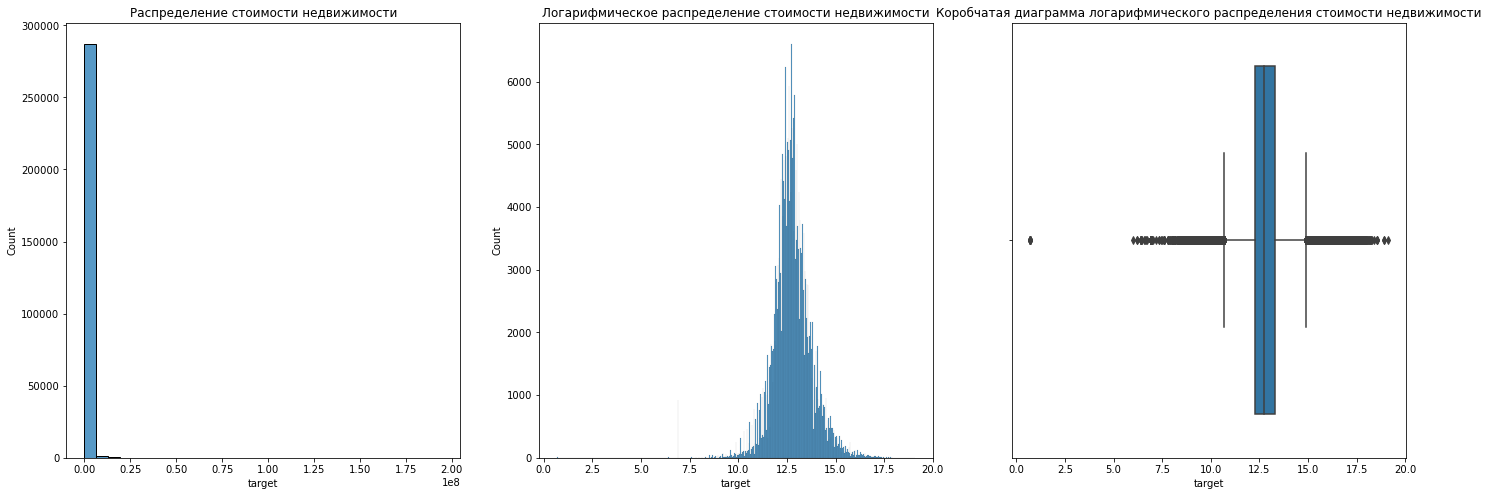

In [29]:
# Зададим параметры:
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 3,
    figsize = (24, 8)
)



# Гистограмма исходного признака 
histplot = sns.histplot(
    data = REA_df['target'],
    bins = 30,
    ax = axes[0]
)

# Название графика
histplot.set_title('Распределение стоимости недвижимости');



# Строим гистограмму
target_log = np.log(REA_df['target'] + 1)
histplot = sns.histplot(
    data = REA_df,
    x = target_log,
    ax = axes[1]
);

# Задаём название гистограммы
histplot.set_title('Логарифмическое распределение стоимости недвижимости')



# Строим коробчатую диаграмму
boxplot = sns.boxplot(
    data = REA_df,
    x = target_log,
    ax = axes[2]
);

# Задаём название коробчатой диаграммы
boxplot.set_title('Коробчатая диаграмма логарифмического распределения стоимости недвижимости')



# Формируем нулевую и альтернативную гипотезы для тестирования данных на нормальность распределения
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отклоняем H0)'

# Задаём уровень значимости
alpha = 0.05

# Тест D'Agostino
_, p = stats.normaltest(target_log)
print('p = %.2f' % p)

# Интерпретация
if p > alpha/2:
    print(H0)
else:
    print(Ha)

Теперь отдельно построим гистограмму прологарифмированного распределения:

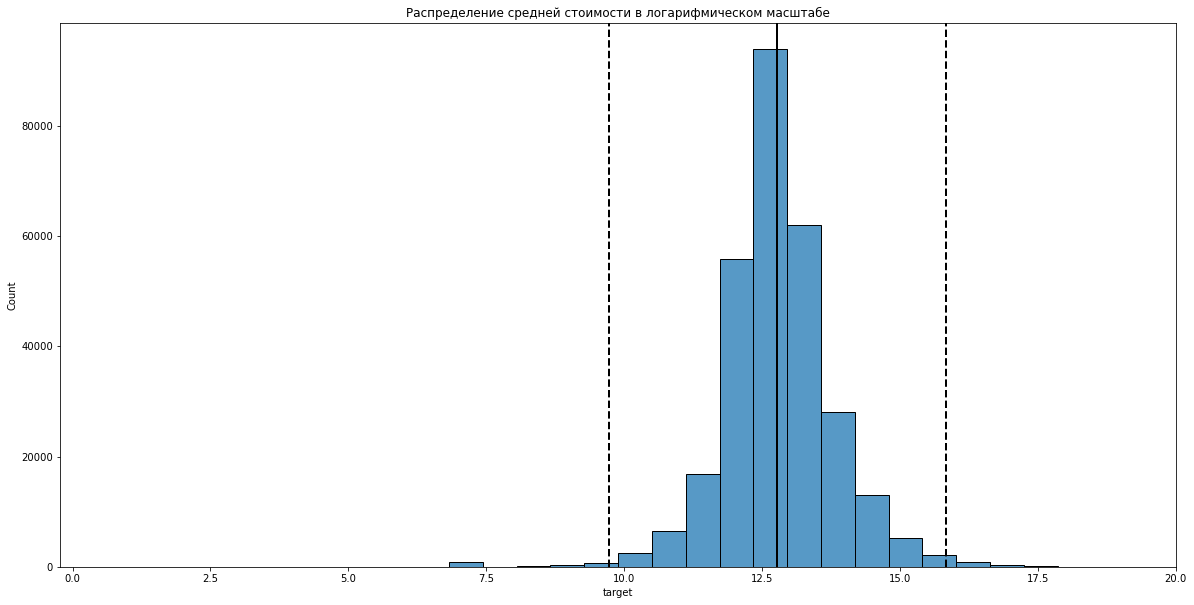

In [30]:
# Задаём параметры графиков
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (20, 10)
)



# Логарифмируем признак
target_log = np.log(REA_df['target'] + 1)



# Строим гистограмму
histplot = sns.histplot(
    data = target_log,
    bins = 30,
    ax = ax
)

# Строим вертикальные линии
histplot.axvline(target_log.mean(), color = 'k', lw = 2)
histplot.axvline(target_log.mean() + 3 * target_log.std(), color='k', ls='--', lw=2)
histplot.axvline(target_log.mean() - 3 * target_log.std(), color='k', ls='--', lw=2)

# Название графика
histplot.set_title('Распределение средней стоимости в логарифмическом масштабе');

Из полученной гисограммы видно, что в данных присутствую выбросы.

Как и для признака `sqft`, для признака `target` напишем функцию **outliers_z_score()**:

In [31]:
def outliers_z_score(data, feature, log_scale = False, left = 2.5, right = 4):
    
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
        
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    data = data[(x > lower_bound) & (x < upper_bound)]
    
    return outliers, data



# Применим полученную функцию к датафрейму и к признаку 'target'
outliers, REA_df = outliers_z_score(REA_df, 'target', log_scale = True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {REA_df.shape[0]}')



# Выводим выбросы
print('\nПотенциальные выбросы: {}'.format(outliers['target'].unique()))

Число выбросов по методу z-отклонения: 3509
Результирующее число записей: 286113

Потенциальные выбросы: [2.400000e+07 2.525000e+04 2.500000e+04 2.599900e+04 1.600000e+04
 2.000000e+04 1.000000e+03 1.750000e+04 6.400000e+03 1.890000e+04
 1.990000e+04 2.750000e+04 1.200000e+04 2.380000e+04 1.500000e+04
 2.875000e+07 5.500000e+03 2.690000e+04 8.000000e+03 2.699900e+04
 2.650000e+04 2.450000e+04 6.900000e+03 2.250000e+04 5.300000e+07
 5.000000e+03 1.400000e+04 1.850000e+04 1.390000e+04 2.600000e+04
 7.700000e+03 3.500000e+03 1.950000e+04 2.500000e+03 5.990000e+07
 4.900000e+03 8.400000e+03 2.465000e+04 9.900000e+03 1.101100e+04
 2.200000e+04 1.790000e+04 1.800000e+04 3.600000e+07 1.450000e+04
 2.700000e+04 3.200000e+07 2.290000e+07 1.499900e+04 1.250000e+04
 1.700000e+04 1.090000e+04 3.000000e+07 1.620000e+04 1.899900e+04
 2.290000e+04 2.500000e+07 1.490000e+04 2.300000e+04 1.690000e+04
 2.590000e+07 4.500000e+07 2.650000e+07 1.481900e+04 8.425000e+03
 5.333000e+03 9.500000e+03 2.590000e+

Повторно построим гистограмму прологарифмированного распределения после удаления выбросов:

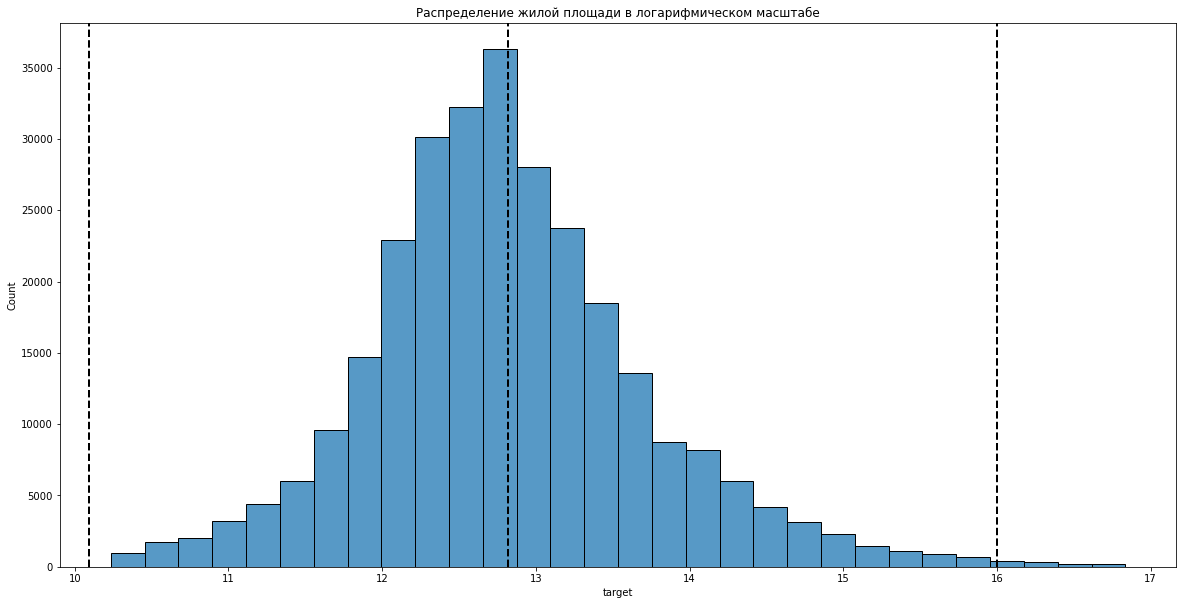

In [32]:
# Задаём параметры графика
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (20, 10)
)



# Логарифмируем признак 'sqft
target_log = np.log(REA_df['target'] + 1)



# Строим гистограмму
histplot = sns.histplot(
    data = target_log,
    bins = 30,
    ax = ax
)

# Строим вертикальные линии
histplot.axvline(target_log.mean(), color='k', ls='--', lw=2)
histplot.axvline(target_log.mean() + 3.5 * target_log.std(), color='k', ls='--', lw=2)
histplot.axvline(target_log.mean() - 3 * target_log.std(), color='k', ls='--', lw=2)

# Название графика
histplot.set_title('Распределение жилой площади в логарифмическом масштабе');

## <center> **`3.` Разведывательный анализ данных (EDA)**

В данной части проекта мы:

* изучаем сгенерированный набор данных;

* постараемся найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие особенности являются решающими при определении стоимости недвижимости;

* дополним наш анализ визуализациями, иллюстрирующими исследование.

Основным показателем качества решения задачи будет метрика **RMSLE (Root Mean Squared Log Error)**, которая рассчитывается на основе целевой переменной в логарифмическом масштабе.

В этом случае целесообразно сразу взять логарифм стоимости недвижимости и считать логарифм целевым знаком при анализе:

$$target\_log = log(target+1),$$

In [33]:
# Возьмём логарифм от целевого признака, при этом создадим новый признак
REA_df['target_log'] = np.log(REA_df['target'] + 1)

#### $3.1$

Построим гистограмму и коробчатую диаграмму, которые помогут нам сравнить распределение стоимости жилья в логарифмическом масштабе (`target_log`) в зависимости от типа жилья (`propertyType`):

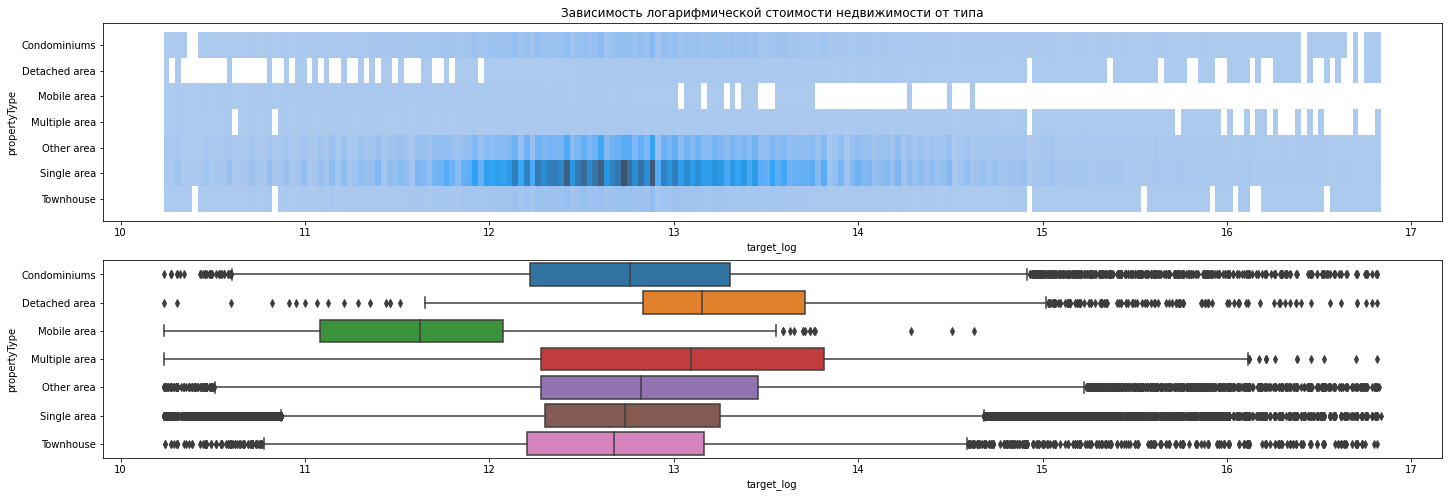

In [34]:
# Преобразовываем тип признака 'propertyType' в категориальный
REA_df['propertyType'] = REA_df['propertyType'].astype('category')



# Задаём параметры графиков
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 1,
    figsize = (24, 8)
)



# Строим гистограмму
histplot = sns.histplot(
    data = REA_df,
    x = 'target_log',
    y = 'propertyType',
    ax = axes[0]
);

# Название гистограммы
histplot.set_title('Зависимость логарифмической стоимости недвижимости от типа')



# Строим коробчатую диаграмму
boxplot = sns.boxplot(
    data = REA_df,
    x = 'target_log',
    y = 'propertyType',
    ax = axes[1]
);

**Вывод:**

Распределения в группах существенно различаются, особенность `propertyType` важна для определения стоимости недвижимости.

#### $3.2$

Проведём небольшое исследование признака `schools_distance_average`:

In [35]:
# Выведем статистику по признаку 'schools_distance_average'
REA_df.schools_distance_average.describe()

count    286113.000000
mean          2.743600
std           6.414993
min           0.020000
25%           1.000000
50%           1.670000
75%           3.000000
max        1590.830000
Name: schools_distance_average, dtype: float64

В данных имеются нулевые значения расстояния от школы до дома. Присвоим им среднее значение расстояния, равное 2.75:

In [36]:
# Производим замену нулевых значений
REA_df[REA_df['schools_distance_average'] == 0] = REA_df[REA_df['schools_distance_average'] == 0].assign(schools_distance_average = 2.75)

# Повторно выведем статистику по признаку 'schools_distance_average'
REA_df.schools_distance_average.describe()

count    286113.000000
mean          2.743600
std           6.414993
min           0.020000
25%           1.000000
50%           1.670000
75%           3.000000
max        1590.830000
Name: schools_distance_average, dtype: float64

Создадим категориальный признак расстояния от школы до дома:

In [37]:
# Создаём функцию, в которой поделим расстояния по определённым категориям
def distance_category(arg):
    if arg < 1:
        return 'less 1'
    elif arg < 3:
        return 'less 3'
    elif arg < 5:
        return 'less 5'
    else:
        return 'more 5'
   
   
    
# Применим полученную функцию к признаку schools_distance_average
REA_df['schools_distance_cat'] = REA_df['schools_distance_average'].apply(distance_category)
REA_df['schools_distance_cat'].value_counts()

less 3    145077
less 1     69254
more 5     38033
less 5     33749
Name: schools_distance_cat, dtype: int64

Построим визуализацию, которая поможет нам сравнить распределение стоимости жилья в логарифмическом масштабе (`target_log`) в зависимости от расстояния до школы (`schools_distance_cat`):

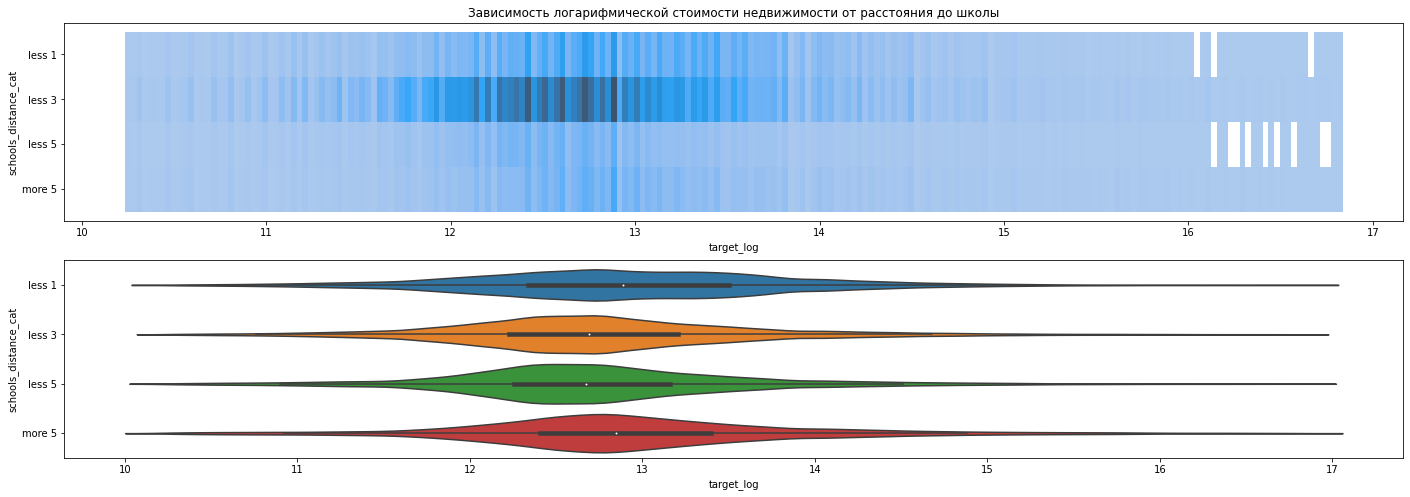

In [38]:
# Преобразовываем тип признака 'schools_distance_cat' в категориальный
REA_df['schools_distance_cat'] = REA_df['schools_distance_cat'].astype('category')



# Задаём параметры графиков
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 1,
    figsize = (24, 8)
)



# Строим гистограмму
histplot = sns.histplot(
    data = REA_df,
    x = 'target_log',
    y = 'schools_distance_cat',
    ax = axes[0]
);

# Название гистограммы
histplot.set_title('Зависимость логарифмической стоимости недвижимости от расстояния до школы')



# Строим скрипичную диаграмму
violinplot = sns.violinplot(
    data = REA_df,
    x = 'target_log',
    y = 'schools_distance_cat',
    ax = axes[1]
);

**Вывод:**

Распределения по группам практически не отличаются, признак `schools_distance_cat` не имеет значения при определении стоимости жилья.

#### $3.3$

Произведём преобразование признака `city`:

In [39]:
# Преобразуем признак 'city' так, что названия городов-миллионеров оставим без изменения, 
# а прочие города обозначим как other
def get_city(arg):
    
    # Создаём список городов «миллионников»
    millionaire_cities = [
        'New York',
        'Los Angeles',
        'Chicago',
        'Houston',
        'Phoenix',
        'Philadelphia',
        'San Antonio',
        'San Diego',
        'Dallas'
    ]
    
    # Выделяем города «миллионники»
    if arg in millionaire_cities:
        return arg
    else:
        return 'Other'
         
    
        
# Применяем полученную функцию к признаку 'city'
REA_df['city'] = REA_df['city'].apply(get_city)

Построим график, на котором отобразим размер средней стоимости жилья `target` в зависимости от города `city`:

Распределение размера средней стоимости жилья по городам: 

           city        target
0       Chicago  5.113412e+05
1        Dallas  7.003454e+05
2       Houston  5.233508e+05
3   Los Angeles  1.942821e+06
4      New York  3.753016e+06
5         Other  5.904506e+05
6  Philadelphia  3.953052e+05
7       Phoenix  2.995728e+05
8   San Antonio  3.079733e+05
9     San Diego  1.024886e+06


c:\Users\ilyaz\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)


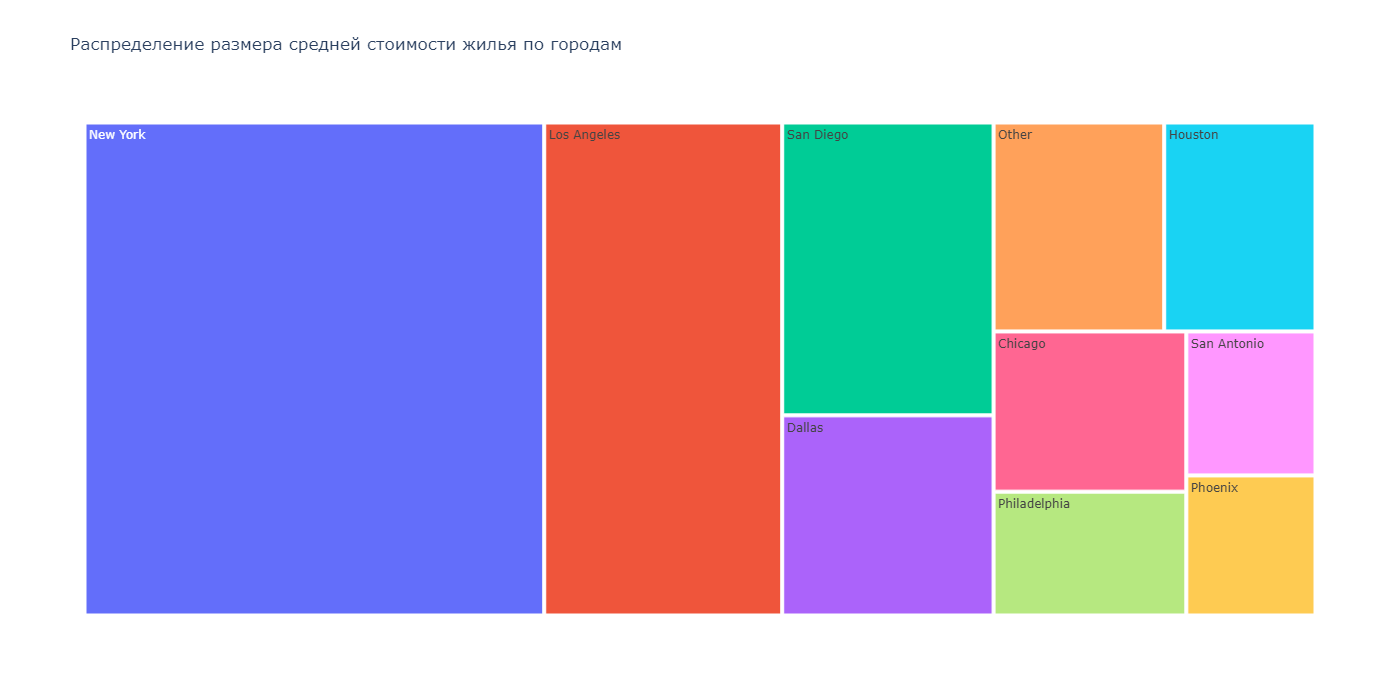

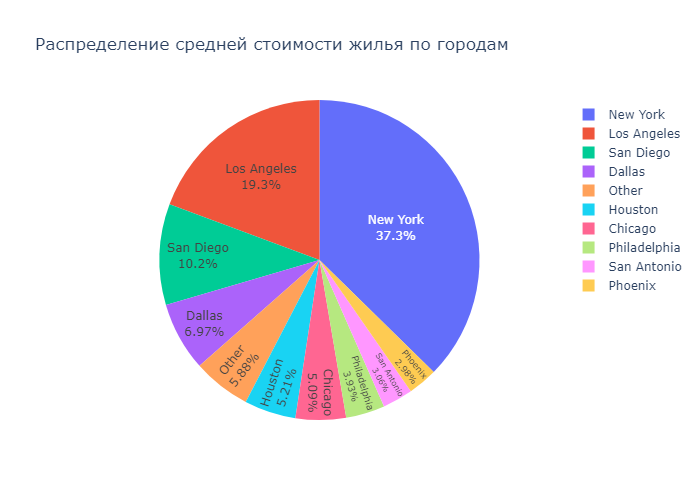

In [40]:
# Считаем среднюю стоимость жилья по городам
treemap_data = REA_df.groupby(
    by = 'city',
    as_index = False,
)[['target']].mean()

# Выводим таблицу
print('Распределение размера средней стоимости жилья по городам: \n\n{}'.format(treemap_data))



# Строим график
fig = px.treemap(
    data_frame = treemap_data,
    path = ['city'],
    values = 'target',
    height = 700,
    width = 1400,
    title = 'Распределение размера средней стоимости жилья по городам'
)

# Отображаем график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = treemap_data,
    values = 'target',
    names = 'city',
    labels = 'city',
    title = 'Распределение средней стоимости жилья по городам'
)

# Выводим график
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.show('png')

**Вывод:**

Попостроенной диаграмме видно, что из всех городов, самые высокие цены на жильё в Нью-Йорке. Данный результат закономерен ввиду того, что данный город является крупнейшим мегаполисом в США с населением около 8 467 513 человек а вмесе с тем, являеся важнейшим экономическим ценорм Америки.

#### $3.4$

Построим распределение стоимости недвижимости `target` по штатам `state`:

Распределение средней стоимости недвижимости по штатам: 

               state        target
19     New York City  1.285434e+06
1         California  1.206255e+06
12     Massachusetts  1.074239e+06
32  Washington, D.C.  9.289434e+05
31        Washington  7.442339e+05
11          Maryland  6.460192e+05
4            Florida  6.070710e+05
23            Oregon  6.004400e+05
2           Colorado  5.964161e+05
30          Virginia  5.955708e+05


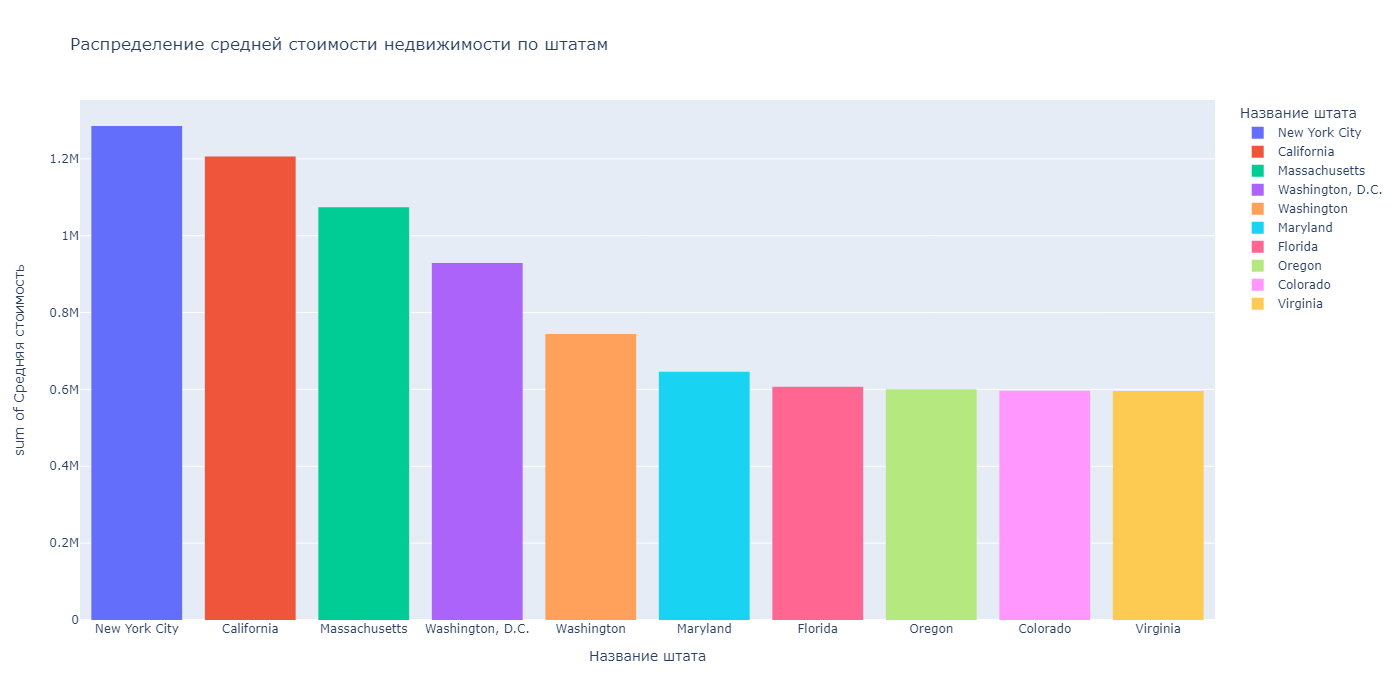

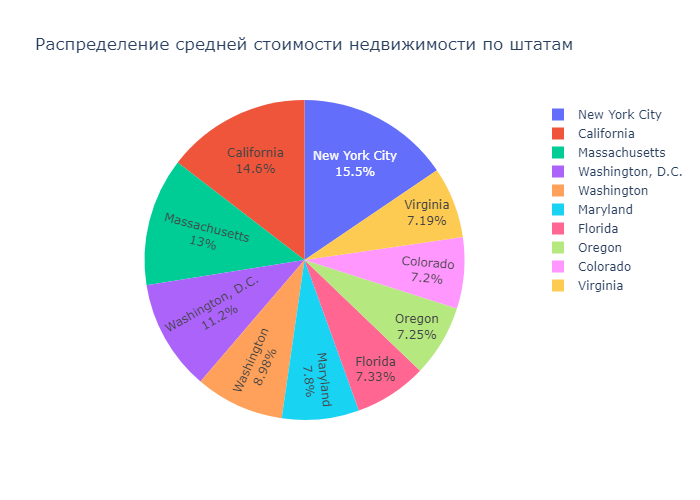

In [41]:
# Создаём DataFrame, в котором отразим зависимость средней стоимости недвижимости от штата
state_group = REA_df.groupby(
    by = 'state',
    as_index = False
)['target'].mean().sort_values(by = 'target', ascending = False).nlargest(10, columns = ['target'])

# Выводим таблицу
print('Распределение средней стоимости недвижимости по штатам: \n\n{}'.format(state_group))


# Строим график
fig = px.histogram(
    data_frame = state_group,
    x = 'state',
    y = 'target',
    color = 'state',
    height = 700,
    width = 1400,
    
    labels = {
        'state': 'Название штата',
        'target': 'Средняя стоимость'
    },
    
    title = 'Распределение средней стоимости недвижимости по штатам'
)

# Выводим график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = state_group,
    values = 'target',
    names = 'state',
    labels = 'state',
    title = 'Распределение средней стоимости недвижимости по штатам'
)

# Задаём параметры графика
fig.update_traces(
    textposition = 'inside',
    textinfo = 'percent+label'
)

# Выводим график
fig.show('png')

**Вывод:**

Аналогично предыдущему графику, Нью-Йорк, являясь также отдельным штатом, занимает самую высокую позицию по стоимости недвижимости. На втором месте находится Калифорния, так как в данном штате распологается самое большое количество корпораций, в следствие чего имеет высокий уровень высококвалифицированных иммигрантов.

#### $3.5$

Построим график изменения стоимости недвижимости по городам, в зависимости от года:

Распределение средней стоимости недвижимости по годам: 

     year built        target
0          1901  1.646617e+06
1          1902  1.065045e+06
2          1903  6.638694e+05
3          1904  7.477430e+05
4          1905  7.963854e+05
..          ...           ...
117        2018  9.222052e+05
118        2019  6.677022e+05
119        2020  7.046547e+05
120        2021  1.795062e+06
121        2022  3.512148e+06

[122 rows x 2 columns]


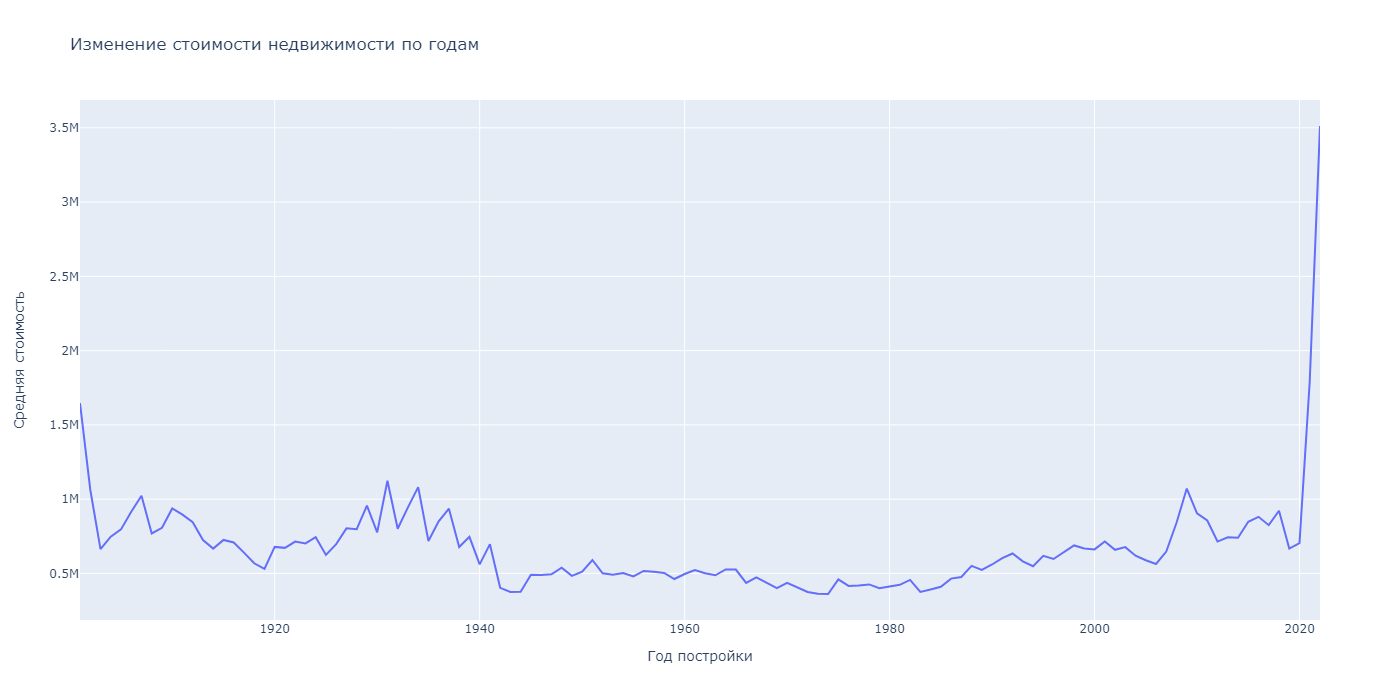

In [42]:
# Проанализируем только те объекты недвижимости, которые были построены после 1900 года
more_modern_buildings = REA_df[REA_df['year built'] > 1900]



# Производим группировку по году постройки
line_data = more_modern_buildings.groupby(
    by = 'year built',
    as_index = False
)['target'].mean()

# Выводим таблицу
print('Распределение средней стоимости недвижимости по годам: \n\n{}'.format(line_data))



# Строим линейный график
fig = px.line(
    data_frame = line_data,
    x = 'year built',
    y = 'target',
    height = 700,
    width = 1400,
    
    labels = {
        'year built': 'Год постройки',
        'target': 'Средняя стоимость'
    },
    
    title = 'Изменение стоимости недвижимости по годам'
)

# Выводим график
fig.show('png')

**Вывод:**

Из данного графика можно заключить, что с конца 19-го по 21-й век средняя стоимость за жильё находилась в промежутке от 500000$ до 1000000$. Начиная с 2020-го года стоимость резко начала расти, что может быть связано с пандемией, когда с понижением ипотечной ставки резко возрос спрос.

## <center> **`4.` Подбор и преобразование признаков**

Посмотрим на содержимое датафрейма:

In [43]:
print('Размер данных: {}'.format(REA_df.shape))
print()
print('Список признаков: {}'.format(REA_df.columns))

Размер данных: (286113, 14)

Список признаков: Index(['propertyType', 'city', 'sqft', 'state', 'target', 'year built',
       'heating', 'cooling', 'parking', 'school_count',
       'schools_rating_average', 'schools_distance_average', 'target_log',
       'schools_distance_cat'],
      dtype='object')


Выделим среди оставшихся признаков категориальные:

* `propertyType`,
* `city`,
* `state`,
* `heating`,
* `cooling`,
* `parking`,
* `schools_distance_cat`.

#### $4.1$

Произведём преобразование признаков `state`, `heating`, `cooling`, `parking` с помощью **BinaryEncoder**, так как количество уникальных значений этих признаков превышают 1000 значений:

In [44]:
# Создаём список признаков для обработки методом BinaryEncoder()
binary_features_list = ['heating', 'cooling', 'parking', 'state']



# Создаём цикл по списку binary_features_list
for feature in binary_features_list:
    
    # Создаём экземпляр класса BinaryEncoder()
    bin_encoder = ce.BinaryEncoder(cols = [feature])
    
    # Кодируем признаки с помощью класса BinaryEncoder()
    data_binary = bin_encoder.fit_transform(REA_df[feature])
    
    # Объединяем датасеты
    REA_df = pd.concat([REA_df, data_binary], axis = 1)
    
    
    
# Выведем количество новых признаков
print('Количество полученных признаков: {}'.format(data_binary.shape[1]))

Количество полученных признаков: 6


#### $4.2$

Признаки `propertyType`, `schools_distance_cat` и `city` обработаем методом **OneHotEncoder**:

In [45]:
# Создаём экземпляр класса OneHotEncoder()
oh_encoder = preprocessing.OneHotEncoder(drop = 'first')

# Создаём список признаков для обработки 
columns_to_change = ['schools_distance_cat', 'city', 'propertyType']

# Кодируем признаки
data_onehot = oh_encoder.fit_transform(REA_df[columns_to_change]).toarray()

# Выделим названия закодированных признаков
oh_columns_names = oh_encoder.get_feature_names_out()

# Создаём новый датафрейм с закодированными признаками
data_onehot = pd.DataFrame(
    data = data_onehot,
    columns = oh_columns_names
)

# Выведем количество новых признаков
print('Количество полученных признаков: {}'.format(data_onehot.shape[1]))

Количество полученных признаков: 18


Добавим закодированные признаки в основную таблицу: 

In [46]:
# Объединяем оба датафрейма
REA_df = pd.concat(
    [REA_df.reset_index(drop = True).drop(columns_to_change, axis = 1), data_onehot],
    axis = 1
)

#### $4.3$

Удалим признаки типа *object*:

In [47]:
object_columns = [features for features in REA_df.columns if REA_df[features].dtype == 'object']
REA_df.drop(object_columns, axis = 1, inplace = True)

# Выведем типипзацию признаков
REA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286113 entries, 0 to 286112
Data columns (total 65 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   sqft                         286113 non-null  float64
 1   target                       286113 non-null  float64
 2   year built                   286113 non-null  int32  
 3   school_count                 286113 non-null  int32  
 4   schools_rating_average       286113 non-null  float64
 5   schools_distance_average     286113 non-null  float64
 6   target_log                   286113 non-null  float64
 7   heating_0                    286113 non-null  int64  
 8   heating_1                    286113 non-null  int64  
 9   heating_2                    286113 non-null  int64  
 10  heating_3                    286113 non-null  int64  
 11  heating_4                    286113 non-null  int64  
 12  heating_5                    286113 non-null  int64  
 13 

#### $4.4$

Проводим корреляционный анализ. Построим тепловую карту корреляций признаков:

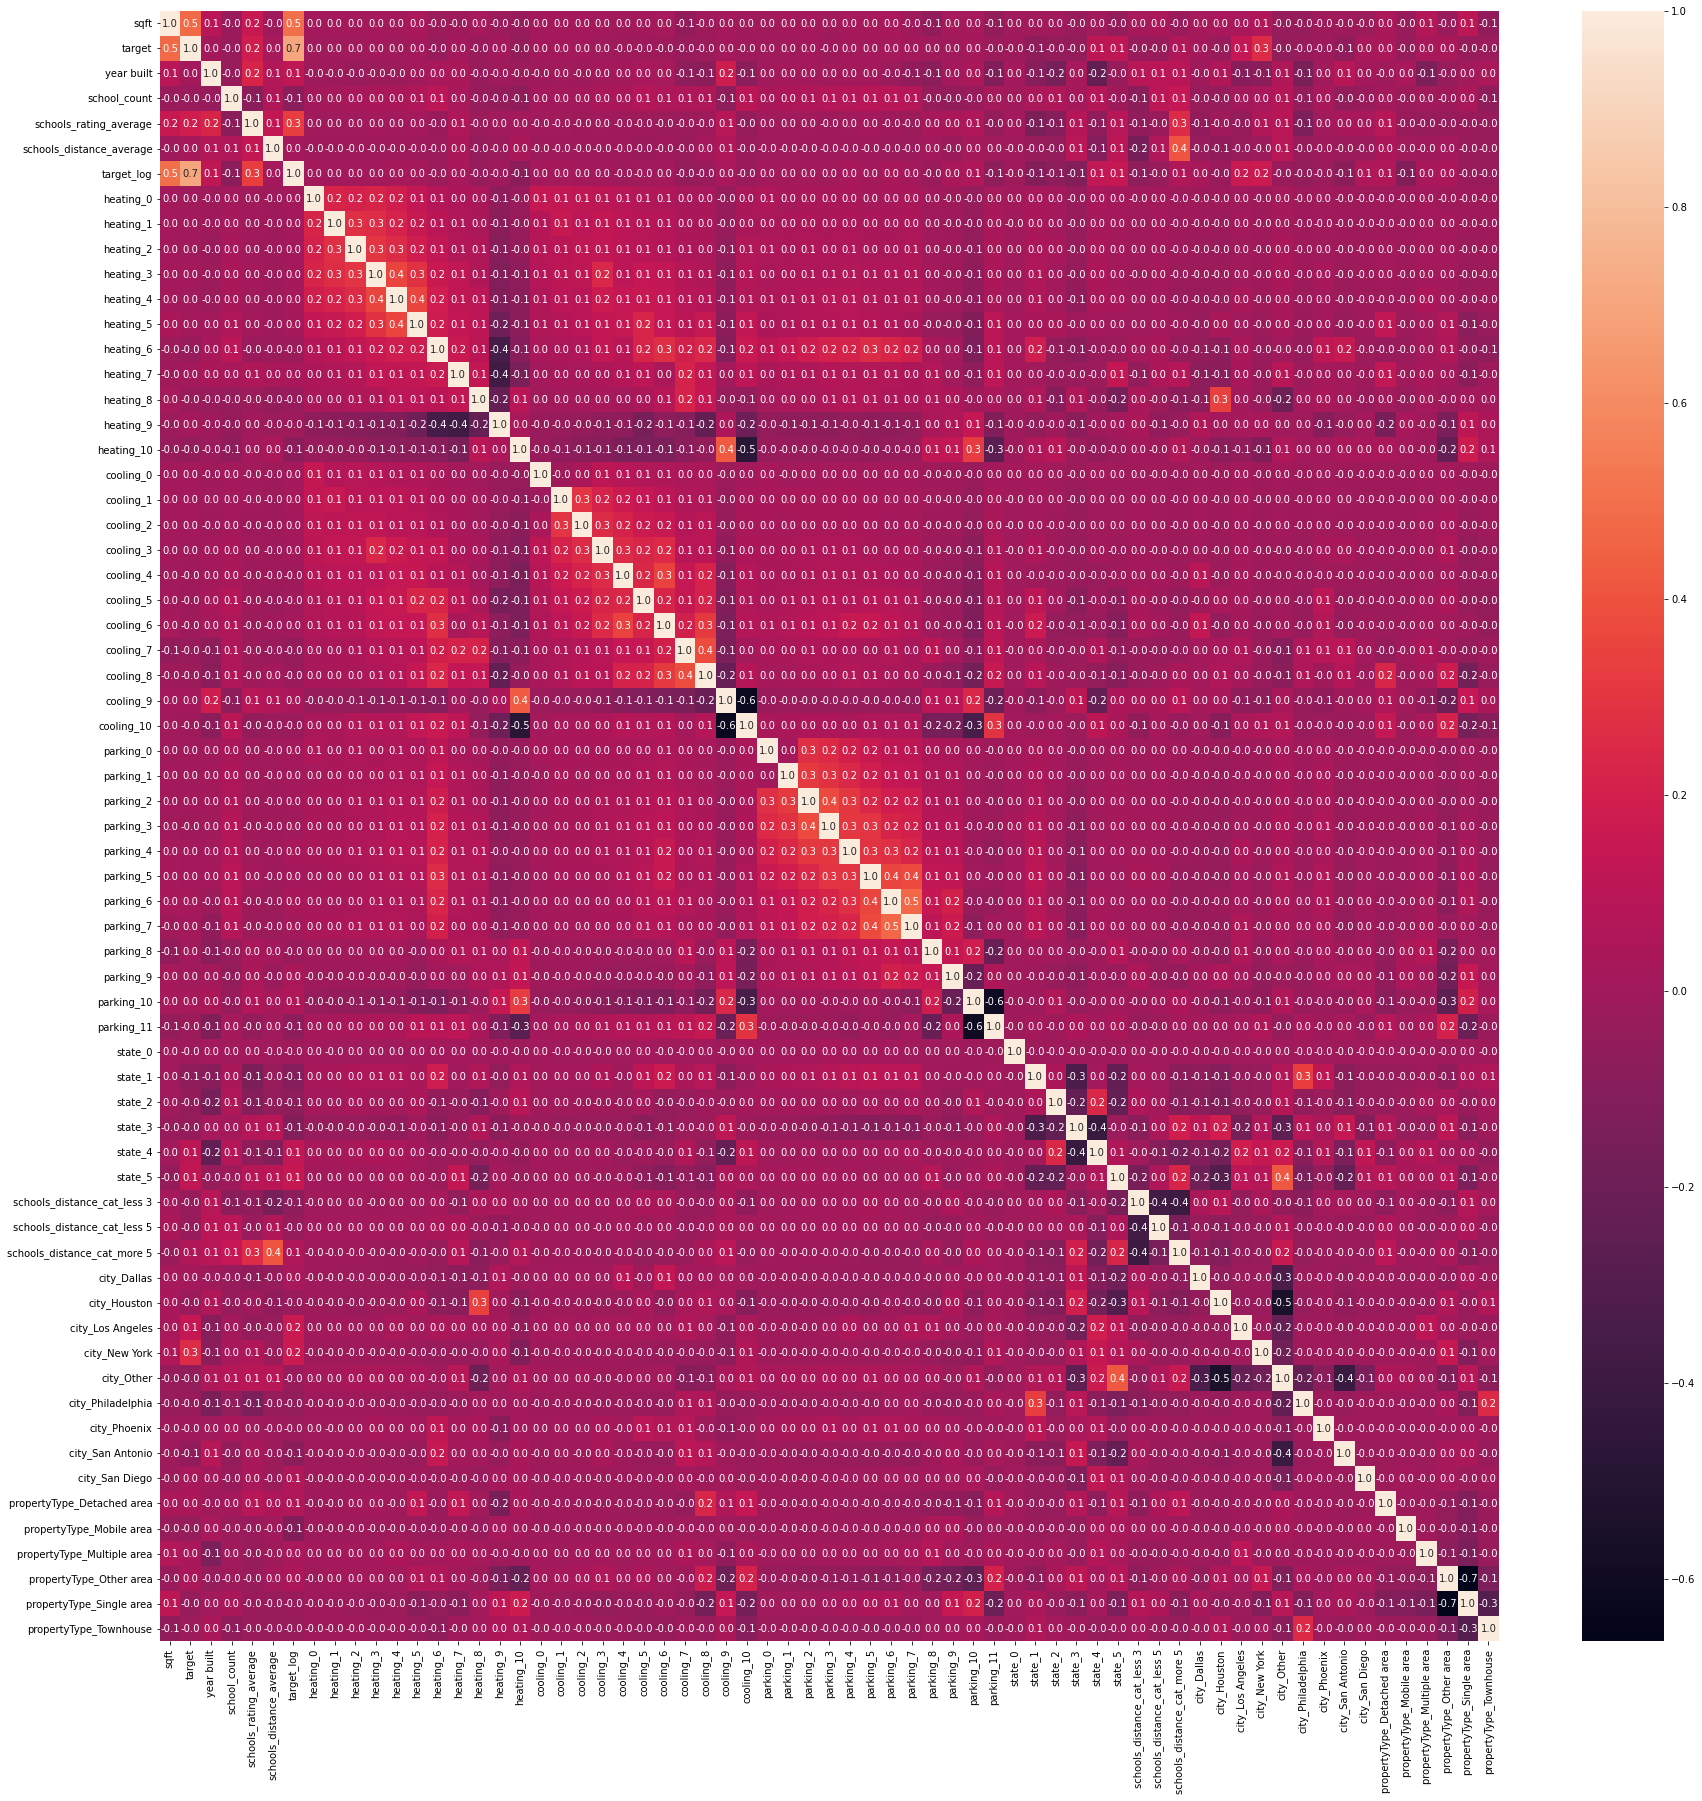

In [48]:
# Задаём параметры графика
plt.rcParams['figure.figsize'] = (30, 30)


# Строим график
sns.heatmap(
    data = REA_df.corr(),
    annot = True,
    fmt = '.1f'
);

**Вывод:**

Исходя из построенной тепловой карты максимальное значение корреляции не превышает 0.7, что вполне допустимо, следовательно высококоррелированных связей небыло обнаружено.

#### $4.5$

Теперь, когда категориальные признаки предварительно обработаны, давайте сформируем матрицу наблюдения `X`, вектор целевой переменной `y` и логарифмической целевой переменной `y_log`:

In [49]:
# Матрица наблюдений X
X = REA_df.drop(columns = ['target', 'target_log'], axis = 1)

# Вектор правильных ответов y
y = REA_df['target']

# Вектор правильных ответов y_log
y_log = REA_df['target_log']

Далее нам необходимо определить **тип валидации** — схему, по которой мы будем оценивать качество построенных моделей.

Разделим выборку на обучающую и проверочную в соотношении 80/20:

In [50]:
# С помощью библиотеки sklearn разделим данные на тренировочную и валидационную
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(X, y_log, test_size = 0.2, random_state = 42)

Выведем размерности:

In [51]:
print('Размер тренировочной выборки: {}'.format(X_train.shape))
print('Размер валидационной выборки: {}'.format(X_valid.shape))

Размер тренировочной выборки: (228890, 63)
Размер валидационной выборки: (57223, 63)


#### $4.6$

Используем алгоритм `SelectKBest` чтобы выделить 25 наиболее важных признаков для предсказания:

In [52]:
# Создаём объект класса SelectKBest()
selector = feature_selection.SelectKBest(
    score_func = feature_selection.f_regression,
    k = 25
)

# Применяем полученный объект к тренировочной выборке
selector.fit(X_train, y_train_log)

# Оставляем только выбранные признаки
important_features = selector.get_feature_names_out()
X_train = X_train[important_features]
X_valid = X_valid[important_features]

# Выведем выбранные признаки
print('При помощи объекта SelectKBest были выбраны следующие признаки:\n {}'.format(important_features))

При помощи объекта SelectKBest были выбраны следующие признаки:
 ['sqft' 'year built' 'school_count' 'schools_rating_average' 'heating_10'
 'cooling_7' 'parking_9' 'parking_10' 'parking_11' 'state_1' 'state_2'
 'state_3' 'state_4' 'state_5' 'schools_distance_cat_less 3'
 'schools_distance_cat_less 5' 'schools_distance_cat_more 5'
 'city_Los Angeles' 'city_New York' 'city_Philadelphia' 'city_San Antonio'
 'city_San Diego' 'propertyType_Detached area' 'propertyType_Mobile area'
 'propertyType_Other area']


#### $4.7$

Произведём нормализацию признаков при помощи алгоритма `MinMaxScaler`, но для начала построим график распределения:

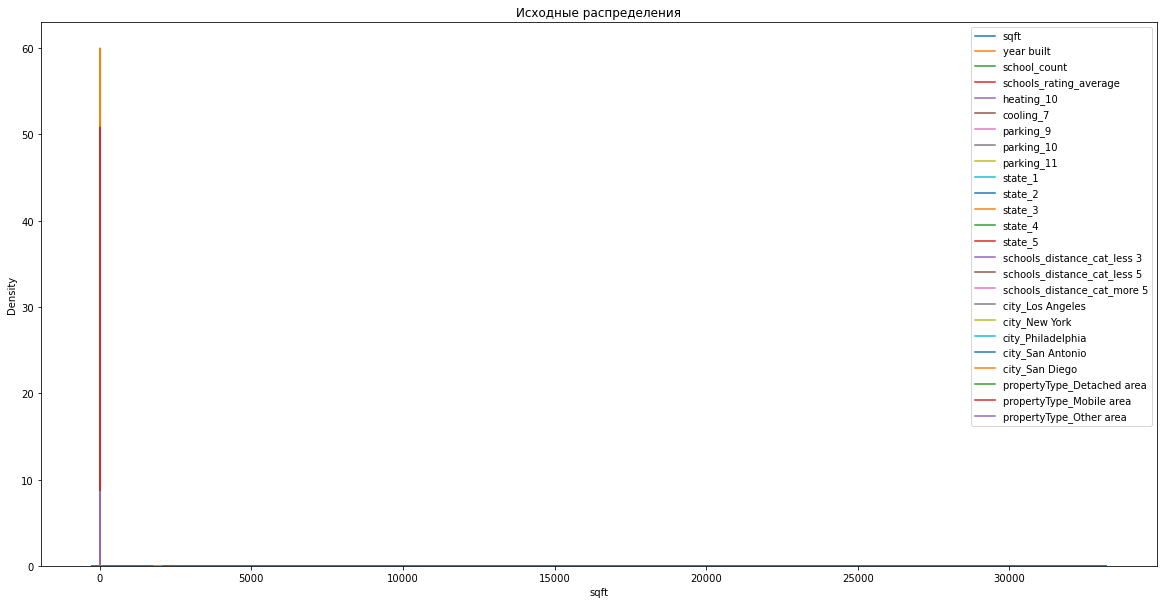

In [53]:
# Задаём параметры графика
fig, (ax) = plt.subplots(
    ncols = 1,
    figsize = (20, 10)
)

# Название графика
ax.set_title('Исходные распределения')



# Строим график
for column in X_train.columns:
    
    sns.kdeplot(
        data = X_train[column],
        ax = ax,
        label = column
    )
    
    
    
# Выводим график
plt.legend()

Произведём преобразование:

In [54]:
# Создаём объект MinMaxScaler()
mm_scaler = preprocessing.MinMaxScaler()

# Кодируем тренировочную и валидационную выборки
X_train = mm_scaler.fit_transform(X_train)
X_valid = mm_scaler.transform(X_valid)

# Вычислим среднее арифметическое для первого предиктора из набора.
# Ответ округлим до второго знака после точки разделителя
print('Арифметическое среднее первого предиктора из валидационной выборки: {}'.format(np.round(np.mean(X_valid[:, 0]), 2)))

# Создадим DataFrame из полученных массивов
X_train = pd.DataFrame(X_train, columns = important_features)
X_valid = pd.DataFrame(X_valid, columns = important_features)

Арифметическое среднее первого предиктора из валидационной выборки: 0.07


Выведем график после нормализации:

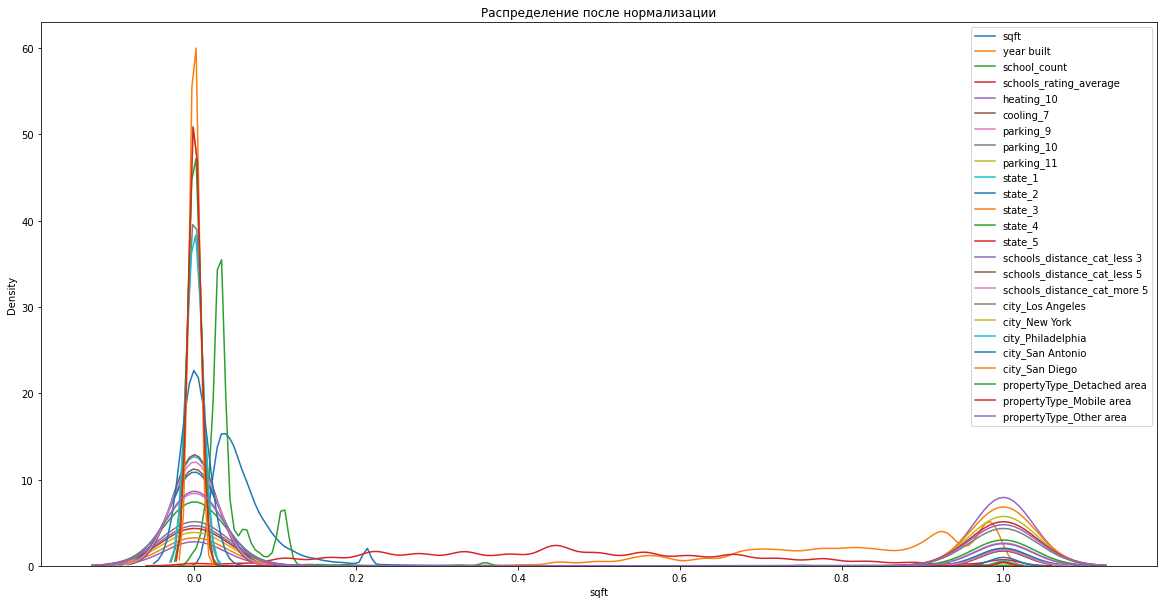

In [55]:
# Задаём параметры графика
fig, (ax) = plt.subplots(
    ncols = 1,
    figsize = (20, 10)
)

# Название графика
ax.set_title('Распределение после нормализации')



# Строим график
for column in X_train.columns:
    
    sns.kdeplot(
        data = X_train[column],
        ax = ax,
        label = column
    )
    
    
    
# Выводим график
plt.legend()

## <center> **`5.` Machine Learning: AutoML**

#### $5.1$

Разделим данные:

In [56]:
# Составляем список факторов (исключили целевой столбец)
features = REA_df.drop('target', axis = 1).columns

# Составляем матрицу наблюдений X, вектор правильных ответов y и логарифмированный вектор правильных ответов y_log
X = REA_df[features]
y = REA_df['target']
y_log = REA_df['target_log']

Определяем константы (количество потоков, таймаут, имя целевой колонки, размер валидационной выборки и так далее):

In [57]:
# Опредиляем константы для lightautoml
N_THREADS = 10
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.33
TIMEOUT = 600
TARGET_NAME = 'target_log'

Для максимальной воспроизводимости решения используем команды: 

In [58]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

#### $5.2$

Разбиваем данные на тренировочную (**80%**, **train_data**) и валидационную (**20%**, **test_data**) выборки:

In [59]:
train_df, test_df = model_selection.train_test_split(
    X,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

In [60]:
# Выведем размеры тренировочной и тестовой части
print(f'Данные разделены. Размеры каждой части: train_data = {train_df.shape}, test_data = {test_df.shape}')

Данные разделены. Размеры каждой части: train_data = (191695, 64), test_data = (94418, 64)


Указываем задачу, которую решаем (задача регрессии **reg**) и указываем метрику (**mae**):

In [61]:
task = Task(
    'reg',
    loss = 'mae',
    metric = 'mae'
)

Указываем роли переменных:

In [62]:
roles = {
    'target': TARGET_NAME,
    'drop': []
}

#### $5.3$

С помощью класса **TabularAutoML** создаём модель **LightAutoML**:

In [63]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    
    reader_params = {
        'n_jobs': N_THREADS,
        'cv': N_FOLDS,
        'random_state': RANDOM_STATE
    }
    
)

#### $5.4$

Обучение тренировочной выборки:

In [64]:
oof_pred = automl.fit_predict(
    train_data = train_df,
    roles = roles,
    verbose = 1
)

[19:08:09] Stdout logging level is INFO.
[19:08:09] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[19:08:09] Task: reg

[19:08:09] Start automl preset with listed constraints:
[19:08:09] - time: 600.00 seconds
[19:08:09] - CPU: 10 cores
[19:08:09] - memory: 16 GB

[19:08:09] Train data shape: (191695, 64)

[19:08:17] Layer 1 train process start. Time left 592.45 secs
[19:08:19] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:08:34] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.4792905984111649
[19:08:34] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:08:34] Time left 575.05 secs

[19:08:47] Selector_LightGBM fitting and predicting completed
[19:08:49] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:09:31] Time limit exceeded after calculating fold 2

[19:09:31] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.3204555572406427
[19:09:31] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting comple

In [65]:
# Выводим информацию об автоматической обработке
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


С помощью метода **fast** построим график, на котором отобразим оценку влияния каждого признака на полученные предсказания:

<AxesSubplot:xlabel='Feature'>

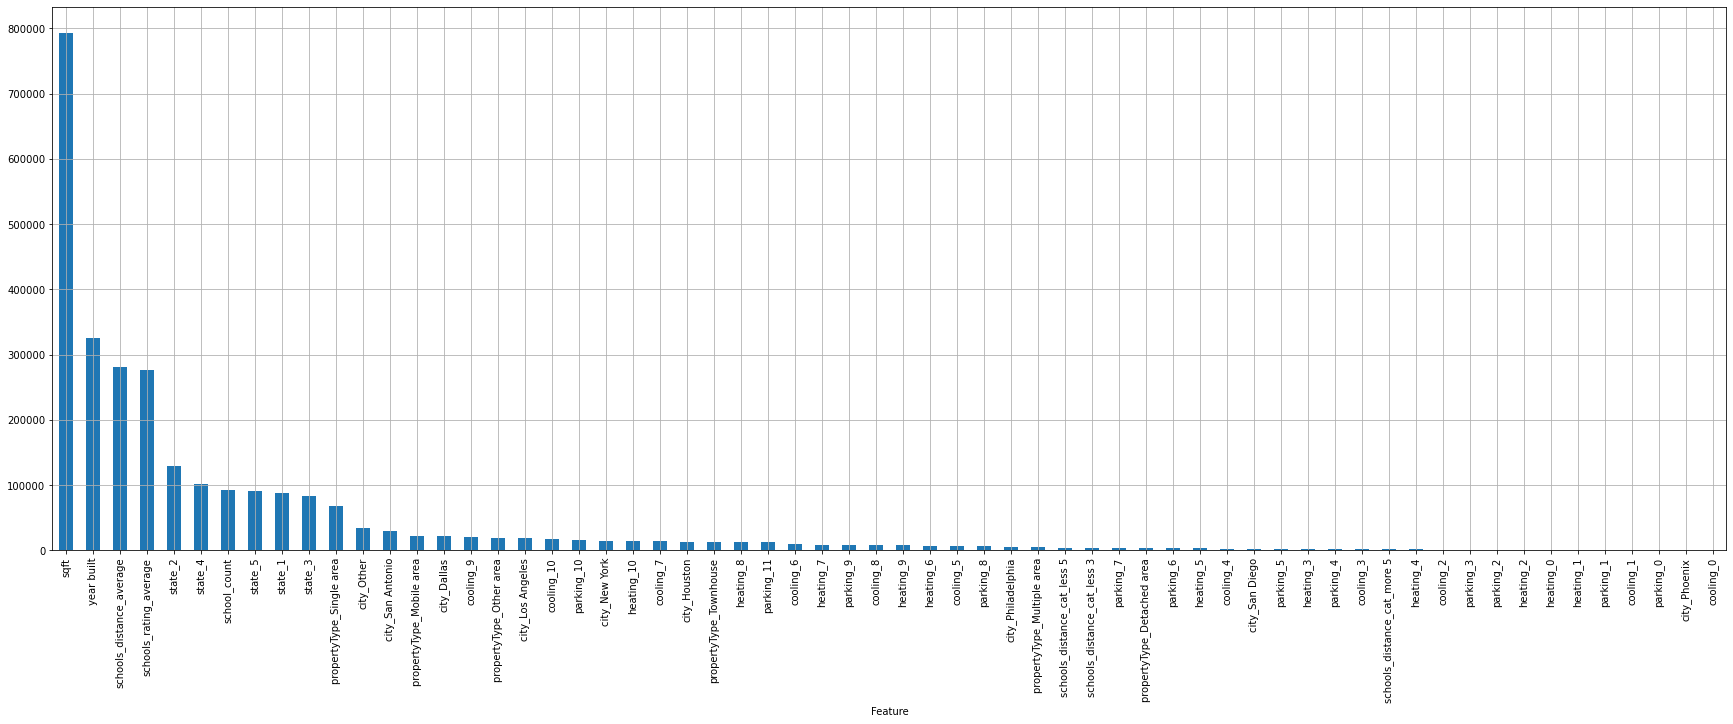

In [66]:
fast_fi = automl.get_feature_scores('fast')

# Строим график
fast_fi.set_index('Feature')['Importance'].plot.bar(
    figsize = (30, 10),
    grid = True
)

#### $5.5$

Обучение валидационной выборки:

In [67]:
test_pred = automl.predict(test_df)
print(f'Предсказание для test_df:\n{test_pred}\nShape = {test_pred.shape}')

Предсказание для test_df:
array([[12.8184595],
       [13.005147 ],
       [14.002466 ],
       ...,
       [12.523238 ],
       [12.371354 ],
       [13.410264 ]], dtype=float32)
Shape = (94418, 1)


In [68]:
# Сравниваем предсказанные значения (test_pred) с реальными (test_data), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(test_df[TARGET_NAME].values, test_pred.data[:, 0])))

MAPE: 0.0232


## <center> **`6.` Machine Learning: Linear Regression and Decision Trees**

Определим метрику, с помощью которой мы будем измерять качество наших моделей. В качестве показателя возьмем **RMSLE (Root Mean Squared Log Error)** которая расчитывается по следующей формуле:

$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$

где:

* $y_i$ - стоимость $i$-й квартиры (`target`);
* $\hat{y_i}$ - предсказанная стоимость $i$-й квартиры.


Так как мы уже взяли логарифм целевой переменной, нам будет достаточно вычислить метрику *RMSLE* для модели, обученной прогнозировать стоимость жилья в логарифмическом масштабе:

$$z_i=log(y_i+1),$$

$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$

#### $6.1$

Построим линейную регрессию на тренировочной выборке (используем целевую переменную в логарифмическом масштабе), при этом оставим все параметры без изменения.

Для полученной модели подсчитаем метрику *RMSLE* на тренировочной и валидационной выборке. Ответ **округлим до второго знака полсе точки разделителя**:

In [69]:
# Создаём объект класса LinearRegression()
lr_regression = linear_model.LinearRegression()

# Обучаем модель
lr_regression.fit(X_train, y_train_log)

# Делаем предсказания на тренировочной и валидационной выборках
y_train_predict = lr_regression.predict(X_train)
y_valid_predict = lr_regression.predict(X_valid)

# Считаем и выводим метрику RMSLE
print('RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict))))
print('RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict))))

print()

# Считаем и выводим метрику MAPE
print('MAPE на тренировочной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log, y_train_predict)))
print('MAPE на валидационной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_valid_log, y_valid_predict)))

RMSLE на тренировочной выборке: 0.69
RMSLE на валидационной выборке: 0.69

MAPE на тренировочной выборке: 0.04
MAPE на валидационной выборке: 0.04


#### $6.2$

Сгенерируем полиномиальные признаки второй степени, используя `PolynomialFeatures` из библиотеки *sklearn*. Возьмем `False` в качестве значения параметра `include_bias`.

Затем мы построим модель полиномиальной регрессии второй степени на обучающем наборе. Все параметры оставим по умолчанию.

Для полученной модели вычислим метрику *RMSLE* на обучающем и валидационном наборах. Ответ **округлим до второго знака после запятой**:

In [70]:
# Создаём генератор полиномиальных признаков PolynomialFeatures()
poly_features = preprocessing.PolynomialFeatures(
    degree = 2,
    include_bias = False
)

# Обучаем модель PolynomialFeatures()
poly_features.fit(X_train)



# Генерируем полиномиальные признаки на тренировочной и тестовой наборах данных
X_train_poly = poly_features.transform(X_train)
X_valid_poly = poly_features.transform(X_valid)



# Создаём объект класса LinearRegression()
lr_regression_poly = linear_model.LinearRegression()

# Обучаем модель
lr_regression_poly.fit(X_train_poly, y_train_log)

# Делаем предсказание для обучающей и валидационной выборок
y_train_predict = lr_regression_poly.predict(X_train_poly)
y_valid_predict = lr_regression_poly.predict(X_valid_poly)

# Считаем и выводим метрику RMSLE
print('RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict))))
print('RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict))))

print()

# Считаем и выводим метрику MAPE
print('MAPE на тренировочной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log, y_train_predict)))
print('MAPE на валидационной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_valid_log, y_valid_predict)))

RMSLE на тренировочной выборке: 0.59
RMSLE на валидационной выборке: 0.59

MAPE на тренировочной выборке: 0.03
MAPE на валидационной выборке: 0.03


**Вывод:**

Исползуя полиномиальные признаки метрику *RMSLE* удалось улучшить на 0.1, а *MAPE* на 0.01. Воспользуемся другими методами с целью улучшения данного показателя.

#### $6.3$

Построим модель полиномиальной регрессии второй степени с $L_2$-регуляризацией (регуляризацией Тихонова) на обучающем наборе. Установим коэффициент регуляризации равным 1, остальные параметры оставим по умолчанию.

Для полученной модели мы вычисляем метрику *RMSLE* на обучающем и проверочном наборах. Ответ **Округлим до второго знака после запятой**:

In [71]:
# Создаём объекта класса линейной регрессии с L2-регуляризацией
lr_regression_ridge = linear_model.Ridge(alpha = 1)

# Обучаем модель
lr_regression_ridge.fit(X_train_poly, y_train_log)

# Делаем предсказание для обучающей и валидационной выборок
y_train_predict = lr_regression_ridge.predict(X_train_poly)
y_valid_predict = lr_regression_ridge.predict(X_valid_poly)

# Считаем и выводим метрику RMSLE
print('RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict))))
print('RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict))))

print()

# Считаем и выводим метрику MAPE
print('MAPE на тренировочной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log, y_train_predict)))
print('MAPE на валидационной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_valid_log, y_valid_predict)))

RMSLE на тренировочной выборке: 0.59
RMSLE на валидационной выборке: 0.59

MAPE на тренировочной выборке: 0.03
MAPE на валидационной выборке: 0.03


**Вывод:**

Используя модель полиномиальной регрессии улучшить метрики не удалось. Воспользуемся другими моделями для улучшения поазателей.

#### $6.4$

Теперь попробуем построить модель дерева решений (**DecisionTreeRegressor**) на обучающем наборе. Все параметры оставим по умолчанию, но установим значение параметра `random_state = 42`.

Для полученной модели мы вычисляем метрику *RMSLE* на обучающем и валидационном наборах. Ответ **округлим до второго знака после запятой**:

In [72]:
# Создаём объекта класса DecisionTreeRegressor()
dt_regression = tree.DecisionTreeRegressor(random_state = 42)

# Обучаем модель
dt_regression.fit(X_train, y_train_log)

# Делаем предсказание для обучающей и валидационной выборок
y_train_predict = dt_regression.predict(X_train)
y_valid_predict = dt_regression.predict(X_valid)

# Считаем и выводим метрику RMSLE
print('RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict))))
print('RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict))))

print()

# Считаем и выводим метрику MAPE
print('MAPE на тренировочной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log, y_train_predict)))
print('MAPE на валидационной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_valid_log, y_valid_predict)))

RMSLE на тренировочной выборке: 0.04
RMSLE на валидационной выборке: 0.62

MAPE на тренировочной выборке: 0.00
MAPE на валидационной выборке: 0.03


#### $6.5$

Перебираем все возможные варианты глубины дерева решений. Построим линейные графики изменения метрики *RMSLE* на обучающей и проверочной выборках в зависимости от значения параметра глубины дерева решений.

Для полученной модели мы вычисляем метрику *RMSLE* на обучающем и валидационном наборах. Ответ **округлим до второго знака после запятой**:

Оптимальная глубина дерева решений: 14
RMSLE на тренировочной выборке: 0.46
RMSLE на валидационной выборке: 0.53


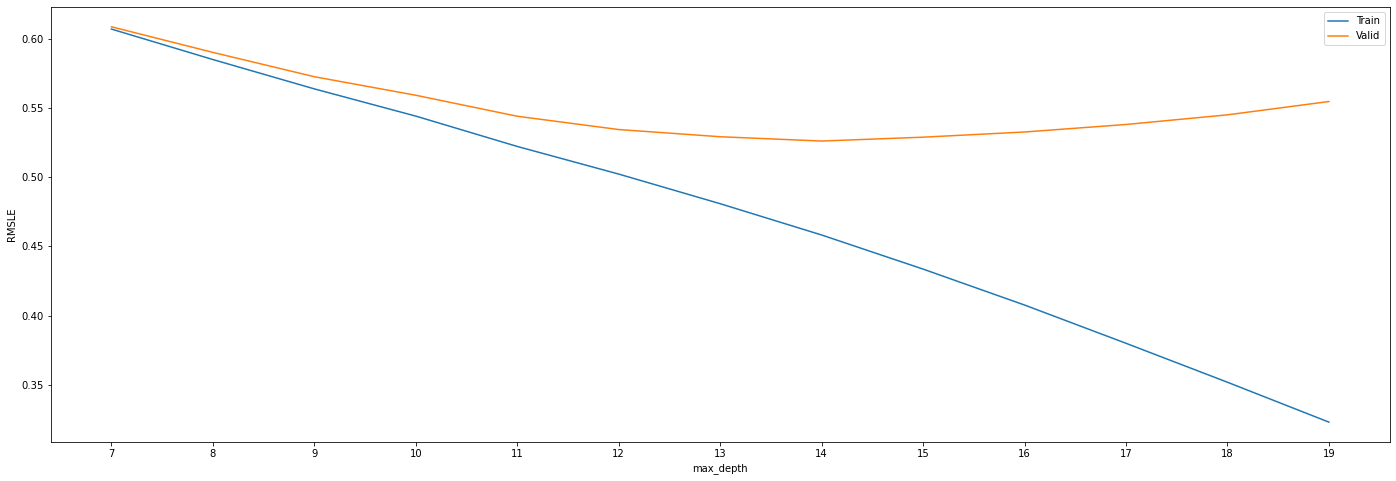

In [73]:
# Создаём диапазон значений от 7 до 20
max_depth_list = range(7, 20)



# Создаём пустые списки для значений глубины для обоих наборов
train_depth_values = []
valid_depth_values = []



# Создаём цикл для перебора значений
for value in max_depth_list:
    
    # Создаём объекта класса DecisionTreeRegressor()
    dt_regression = tree.DecisionTreeRegressor(
        max_depth = value,
        random_state = 42
    )
    
    # Обучаем модель
    dt_regression.fit(X_train, y_train_log)
    
    # Делаем предсказание для обучающей и валидационной выборок
    y_train_predict = dt_regression.predict(X_train)
    y_valid_predict = dt_regression.predict(X_valid)
    
    # Считаем и выводим метрику RMSLE
    train_depth_values.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)))
    valid_depth_values.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)))
    
    
    
# Построение линейных графиков метрик RMSLE
fig, ax = plt.subplots(figsize = (24, 8))
ax.plot(max_depth_list, train_depth_values, label = 'Train')
ax.plot(max_depth_list, valid_depth_values, label = 'Valid')
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSLE')
ax.set_xticks(max_depth_list)
ax.legend();

# Извлекаем индекс лучшего RMSLE в наборе проверки
best_index = valid_depth_values.index(min(valid_depth_values))
print('Оптимальная глубина дерева решений: {}'.format(max_depth_list[best_index], 2))
print('RMSLE на тренировочной выборке: {}'.format(round(train_depth_values[best_index], 2)))
print('RMSLE на валидационной выборке: {}'.format(round(valid_depth_values[best_index], 2)))

## <center> **`7.` Machine Learning: Ensemble Methods and Building a Forecast**

#### $7.1$

Построим модель случайного леса на тренировочной выборке. Зададим следующие гиперпараметры:

* `n_estimators = 200`;
* `max_depth = 14`;
* `criterion = 'squared_error'`;
* `min_samples_split = 20`;
* `random_state = 42`.

Для полученной модели рассчитаем метрику *RMSLE* на тренировочной и валидационной выборках. Ответ округлим до **второго знака после точки разделителя**:

In [74]:
# Создаем объект класса RandomForestRegressor()
rf_regression = ensemble.RandomForestRegressor(
    
    n_estimators = 200,
    max_depth = 14,
    criterion = 'squared_error',
    min_samples_split = 20,
    random_state = 42
    
)

# Обучаем модель на тренировочной выборке
rf_regression.fit(X_train, y_train_log)

# Делаем предсказание на тренировочной и валидационной выборке
y_train_predict = rf_regression.predict(X_train)
y_valid_predict = rf_regression.predict(X_valid)

# Считаем и выводим метрику RMSLE
print('RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict))))
print('RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict))))

print()

# Считаем и выводим метрику MAPE
print('MAPE на тренировочной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log, y_train_predict)))
print('MAPE на валидационной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_valid_log, y_valid_predict)))

RMSLE на тренировочной выборке: 0.45
RMSLE на валидационной выборке: 0.49

MAPE на тренировочной выборке: 0.03
MAPE на валидационной выборке: 0.03


#### $7.2$

Теперь построим модель градиентного бустинга для задачи регрессии (`GradientBoostingRegressor`) на тренировочной выборке. При построении модели используем следующие гиперпараметры:

* `learning_rate` = 0.5;
* `n_estimators` = 100;
* `max_depth` = 6;
* `min_samples_split` = 30;
* `random_state` = 42.

Для полученной модели рассчитаем метрику *RMSLE* на тренировочной и валидационной выборках. Ответ **округлим до двух знаков после точки разделителя**.

In [75]:
# Создаем объект класса GradientBoostingRegressor()
gb_regressor = ensemble.GradientBoostingRegressor(
    
    learning_rate = 0.5,
    n_estimators = 100,
    max_depth = 6,
    min_samples_split = 30,
    random_state = 42
    
)

# Обучаем модель на тренировочной выборке
gb_regressor.fit(X_train, y_train_log)

# Делаем предсказание на тренировочной и валидационной выборке
y_train_predict = gb_regressor.predict(X_train)
y_valid_predict = gb_regressor.predict(X_valid)

# Считаем и выводим метрику RMSLE
print('RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict))))
print('RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict))))

print()

# Считаем и выводим метрику MAPE
print('MAPE на тренировочной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log, y_train_predict)))
print('MAPE на валидационной выборке: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_valid_log, y_valid_predict)))

RMSLE на тренировочной выборке: 0.46
RMSLE на валидационной выборке: 0.48

MAPE на тренировочной выборке: 0.03
MAPE на валидационной выборке: 0.03


#### $7.3$

Построим столбчатую диаграмму, на которой отобразим важность каждого признака:

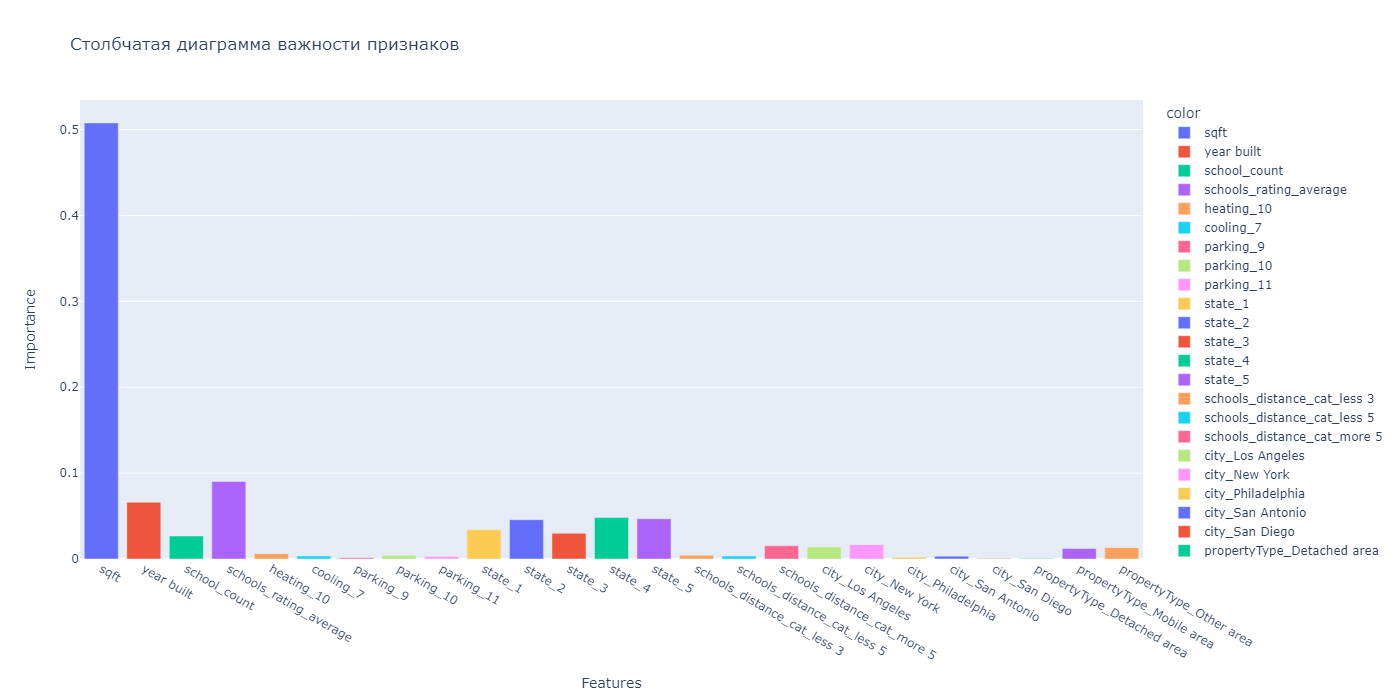

In [76]:
# Задаем параметры графика
features = X_train.columns
features_importances = gb_regressor.feature_importances_



# Строим график
fig = px.bar(
    x = features,
    y = features_importances,
    color = features,
    orientation = 'v',
    height = 700,
    width = 1400,
    
    labels = {
        'x': 'Features',
        'y': 'Importance'
    },
    
    title = 'Столбчатая диаграмма важности признаков'
)

# Выводим график
fig.show('png')

#### $7.4$

Для лучшей модели рассчитаем метрику *MeAE* (**median_absolute_error**) для предсказанной стоимости недвижимости на валидационной выборке:

$$ MeAE = median(|y_i-\hat{y_i}|)$$

In [77]:
# Переведем значения стоимости из логарифмических размеров в стандартные
y_valid = np.exp(y_valid_log) - 1
y_valid_predict_exp = np.exp(y_valid_predict) - 1

# Рассчитываем значение метрики
mae_valid = metrics.median_absolute_error(y_valid, y_valid_predict_exp)

# Выводим значение метрики
print('MeAE на валидационной выборке: {}$.'.format(round(mae_valid)))

MeAE на валидационной выборке: 81794$.


## <center> **`8.` Improving prediction with the XGBoost model**

#### $8.1$

Перед обучением модели, приведем датасеты к типу `xgb.DMatrix`:

In [78]:
# Создадим матрицы наблюдения в формате DMatrix
dtrain = xgb.DMatrix(X_train, label = y_train_log, feature_names = list(important_features))
dvalid = xgb.DMatrix(X_valid, label = y_valid_log, feature_names = list(important_features))

Обучаем модель *XGBoost* методом `train()`:

In [79]:
# Задаем гиперпараметры модели
xgb_params = {
    'min_child_weight': 20,
    'eta': 0.1,
    'colsample_bytree': 0.9,
    'max_depth': 6,
    'subsample': 0.9,
    'lambda': 1,
    'nthread': -1,
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror'
}

# Тренировочная и валидационная выборки
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Обучаем модель XGBoost
xgb_model = xgb.train(
    params = xgb_params,
    dtrain = dtrain,
    num_boost_round = 300,
    evals = watchlist,
    early_stopping_rounds = 20,
    maximize = False,
    verbose_eval = 10
)

[0]	train-rmse:11.12308	valid-rmse:11.11602
[10]	train-rmse:3.92159	valid-rmse:3.91810


[20]	train-rmse:1.46891	valid-rmse:1.46708
[30]	train-rmse:0.72371	valid-rmse:0.72456
[40]	train-rmse:0.55656	valid-rmse:0.55924
[50]	train-rmse:0.52419	valid-rmse:0.52760
[60]	train-rmse:0.51391	valid-rmse:0.51795
[70]	train-rmse:0.50848	valid-rmse:0.51295
[80]	train-rmse:0.50471	valid-rmse:0.50963
[90]	train-rmse:0.50059	valid-rmse:0.50615
[100]	train-rmse:0.49769	valid-rmse:0.50371
[110]	train-rmse:0.49405	valid-rmse:0.50058
[120]	train-rmse:0.49184	valid-rmse:0.49881
[130]	train-rmse:0.48964	valid-rmse:0.49692
[140]	train-rmse:0.48774	valid-rmse:0.49540
[150]	train-rmse:0.48596	valid-rmse:0.49397
[160]	train-rmse:0.48450	valid-rmse:0.49280
[170]	train-rmse:0.48294	valid-rmse:0.49158
[180]	train-rmse:0.48114	valid-rmse:0.49018
[190]	train-rmse:0.47920	valid-rmse:0.48856
[200]	train-rmse:0.47816	valid-rmse:0.48782
[210]	train-rmse:0.47723	valid-rmse:0.48725
[220]	train-rmse:0.47607	valid-rmse:0.48640
[230]	train-rmse:0.47537	valid-rmse:0.48592
[240]	train-rmse:0.47423	valid-rmse:0.48

Произведем предсказание целевого признака с помощью метода `predict()`:

In [80]:
# Делаем предсказание валидационной выборки
y_test_predict = np.exp(xgb_model.predict(dvalid)) - 1
print('Modeling RMSLE %.2f' % xgb_model.best_score)

Modeling RMSLE 0.48


#### $8.2$

Определим коэффициенты важности факторов с помощью функции `plot_importance()`:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

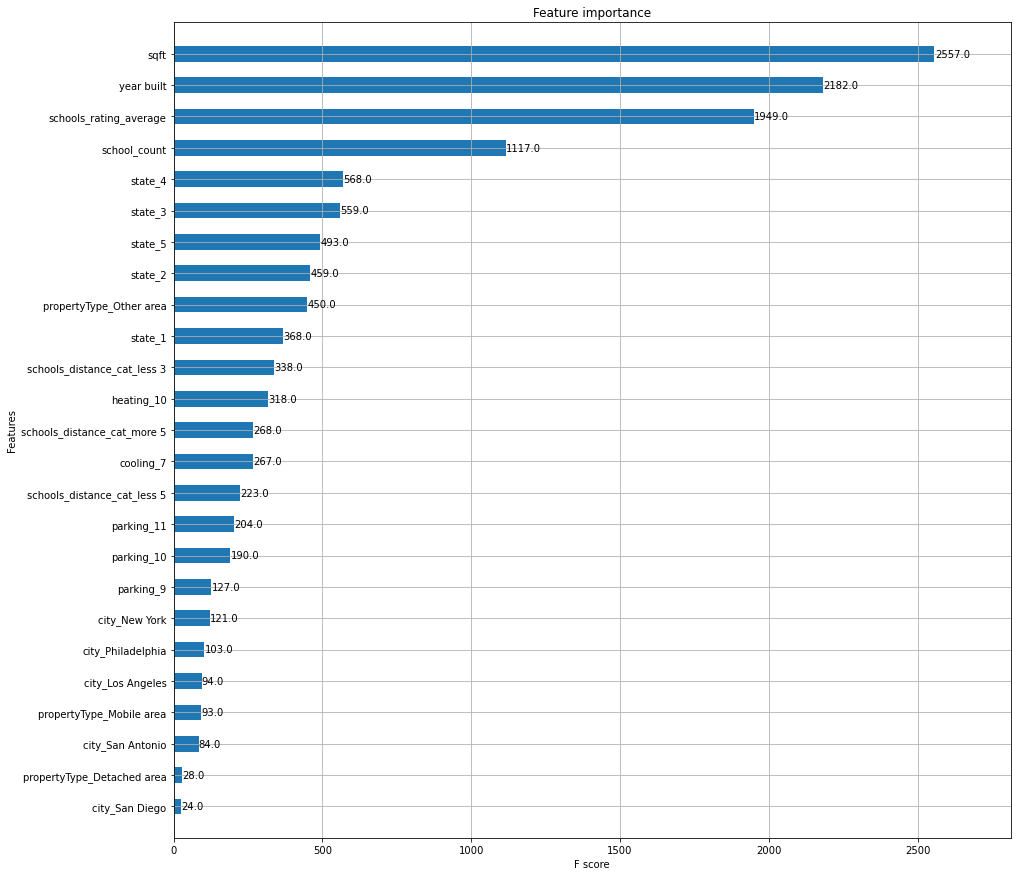

In [81]:
# Зададим параметры графика
fig, ax = plt.subplots(figsize = (15, 15))

# Строим график
xgb.plot_importance(
    xgb_model,
    ax = ax,
    height = 0.5
)

## <center> **Вывод**

Среди задейсвованных моделей, наилучшего результата удалось получить с помощью модели **RandomForestRegressor()**. 

Метрики получились следующие: 

* *RMSLE* на тренировочной выборке: 0.45
* *RMSLE* на валидационной выборке: 0.49

* *MAPE* на тренировочной выборке: 0.03
* *MAPE* на валидационной выборке: 0.03